/home/gant/.local/lib/python3.8/site-packages/skimage/measure/fit.py:896: UserWarning: No inliers found. Model not fitted
  warn("No inliers found. Model not fitted")
/tmp/ipykernel_34655/1101222292.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 6))


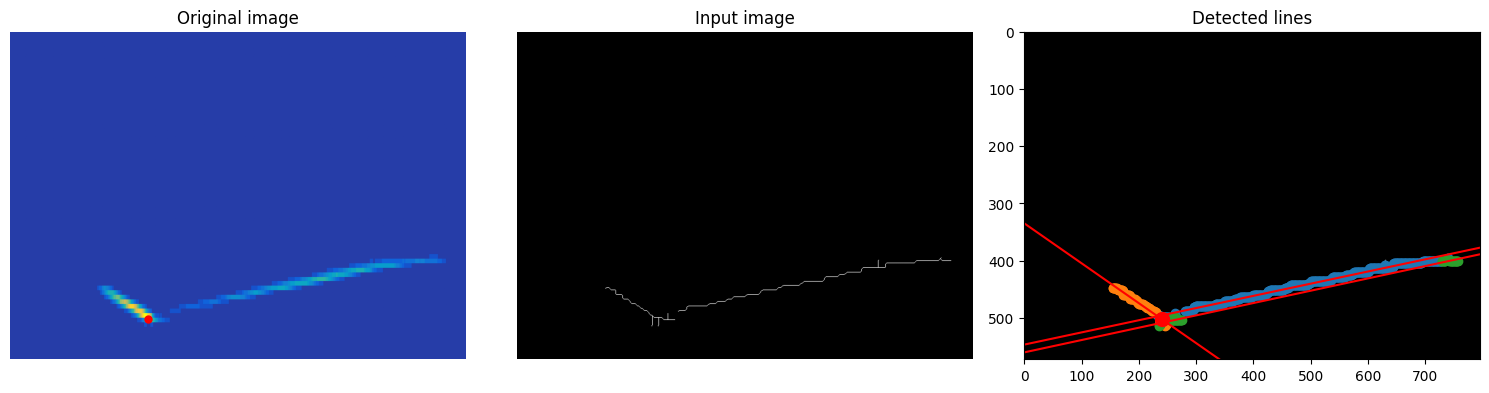

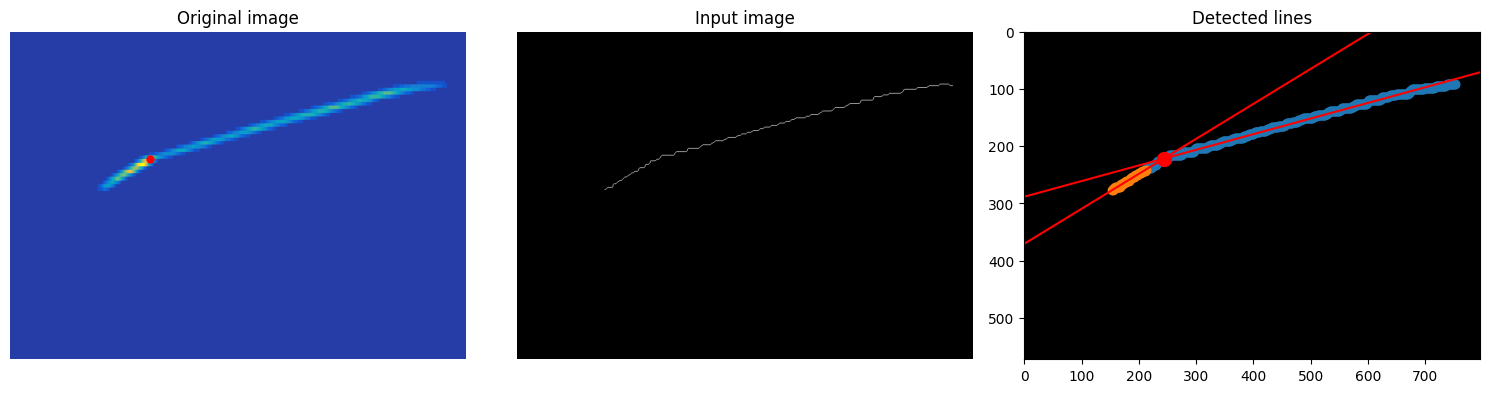

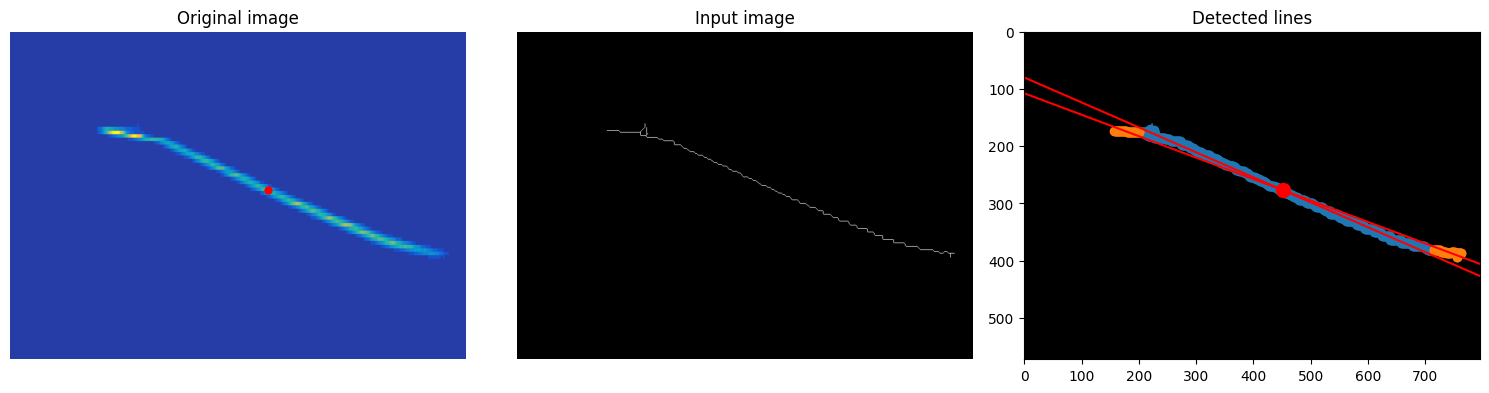

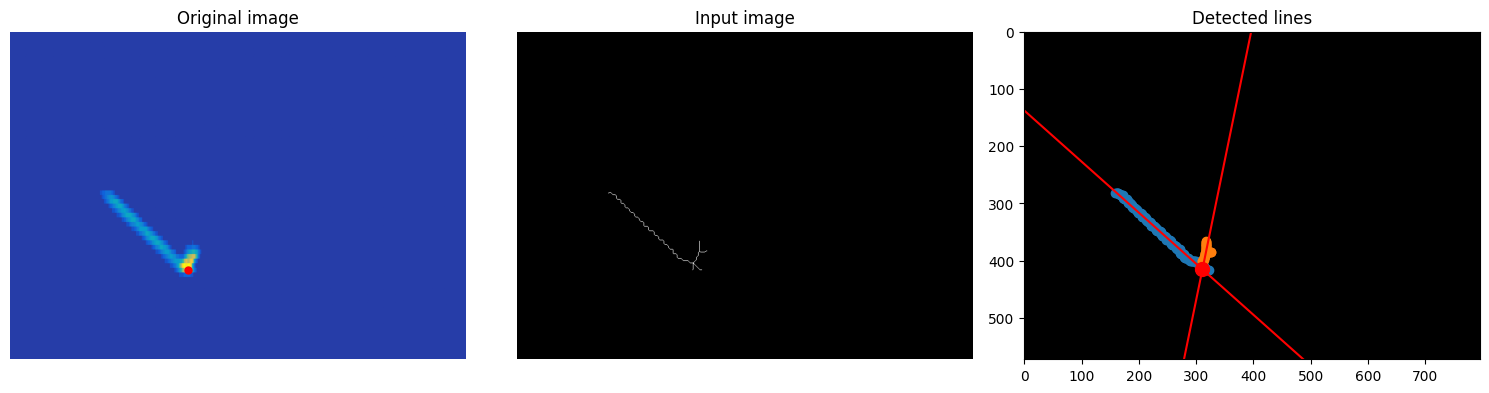

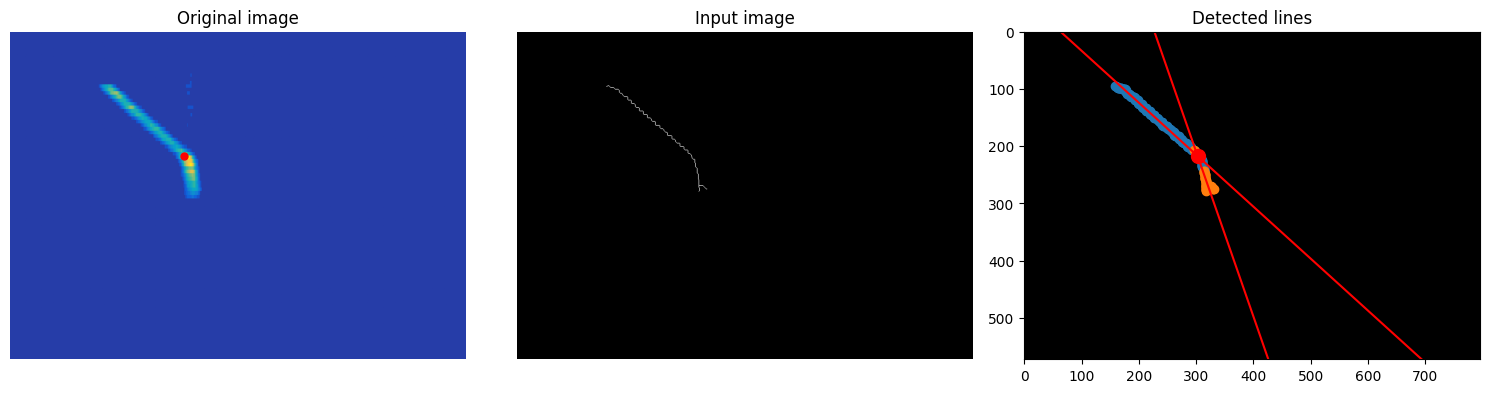

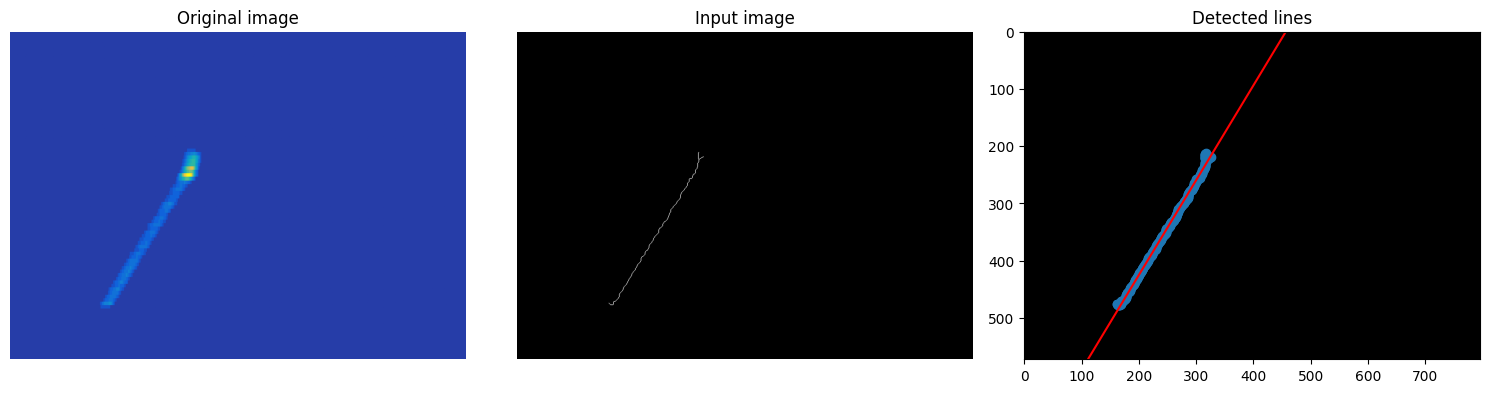

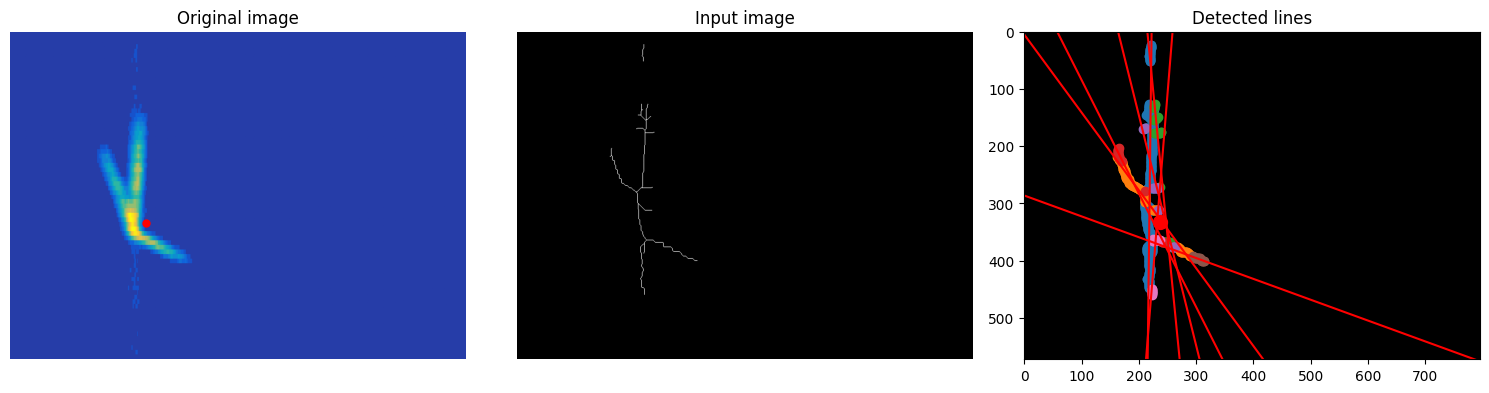

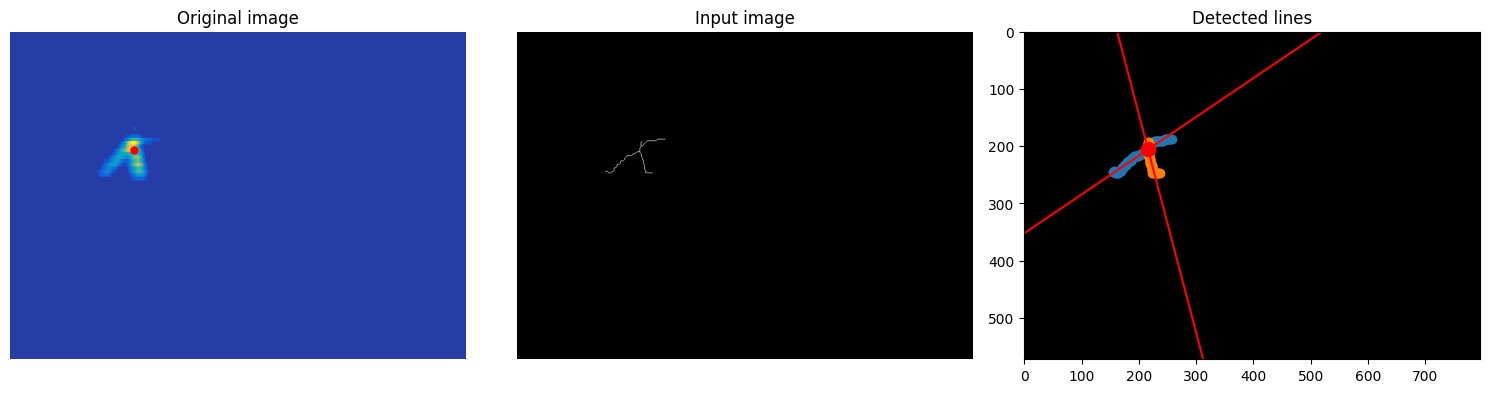

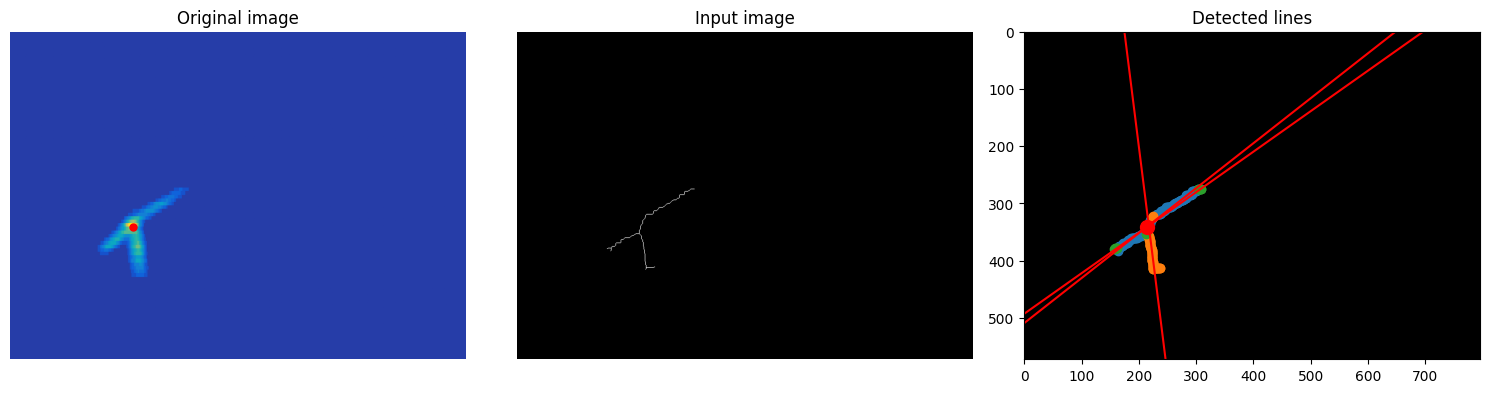

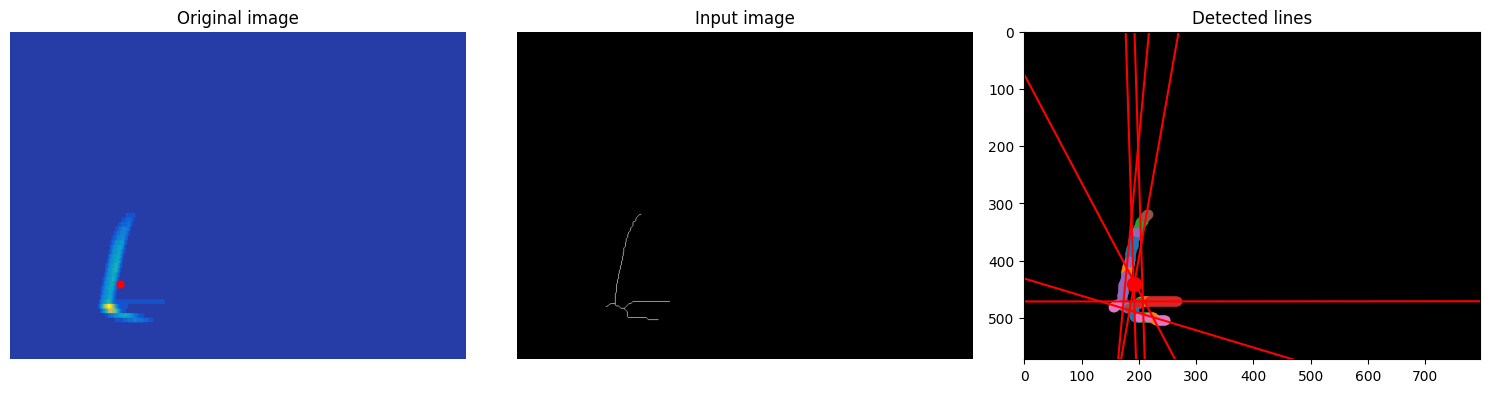

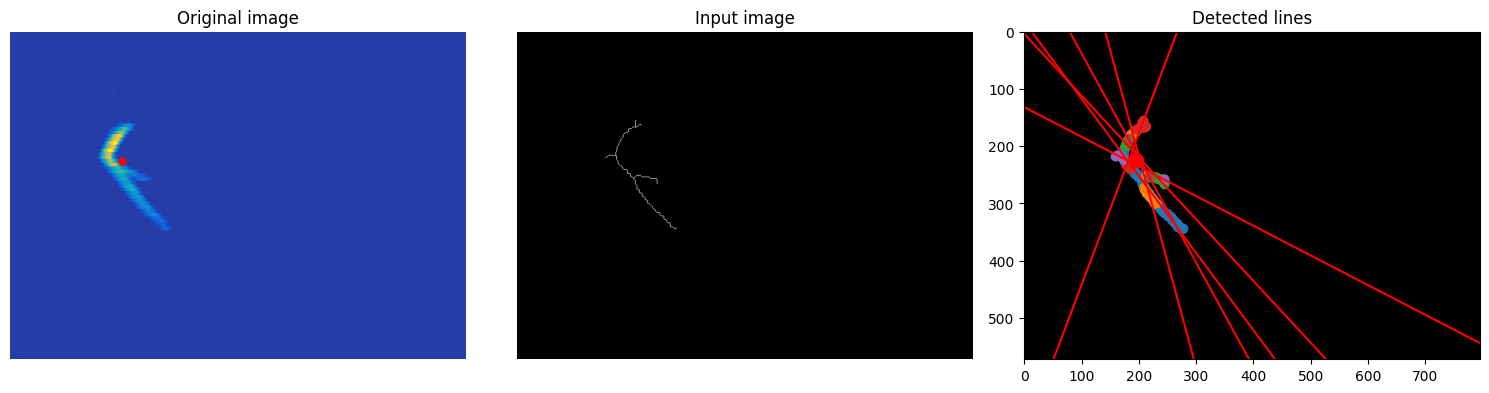

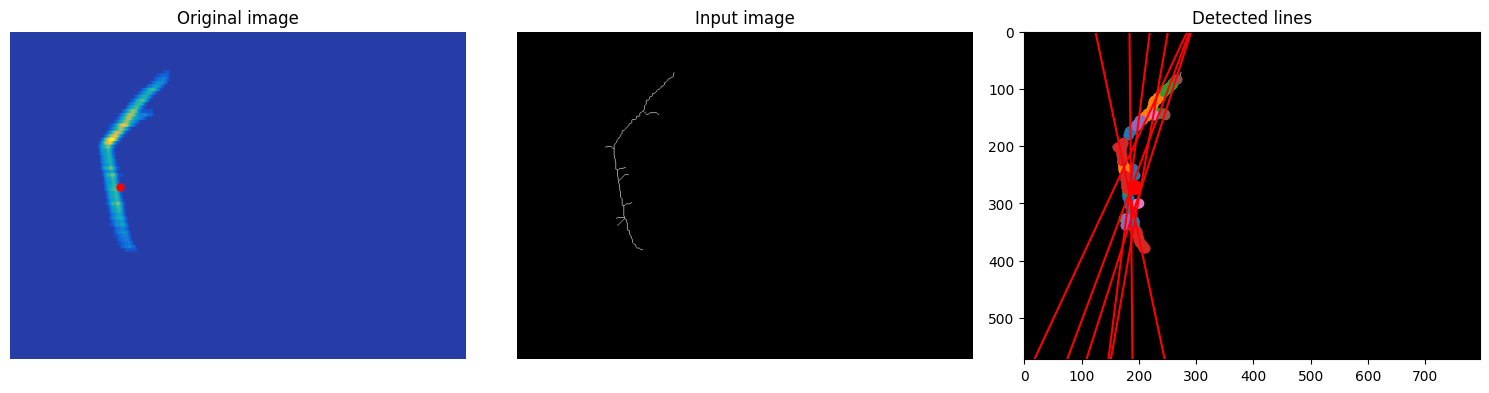

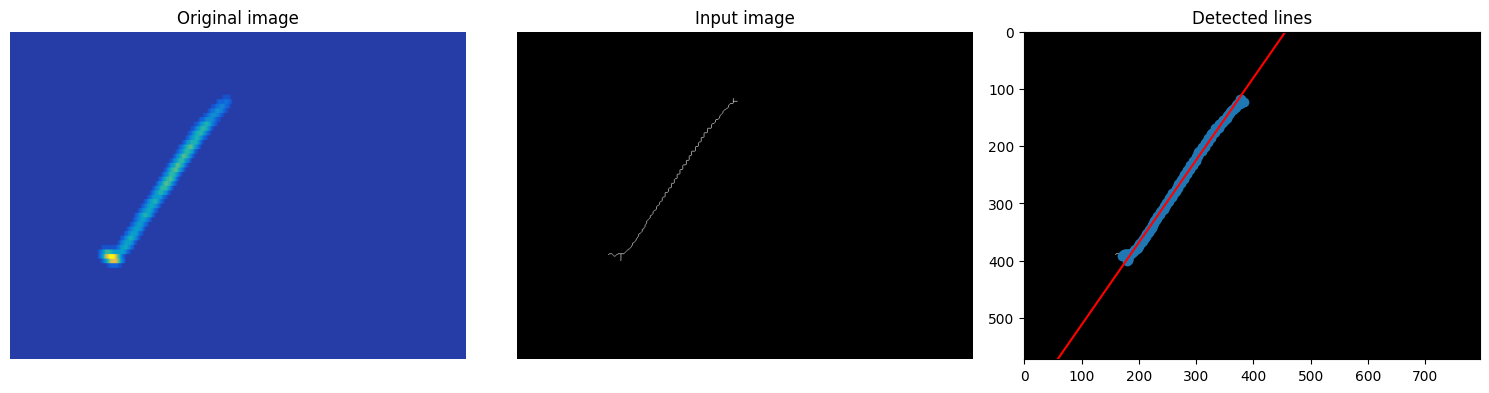

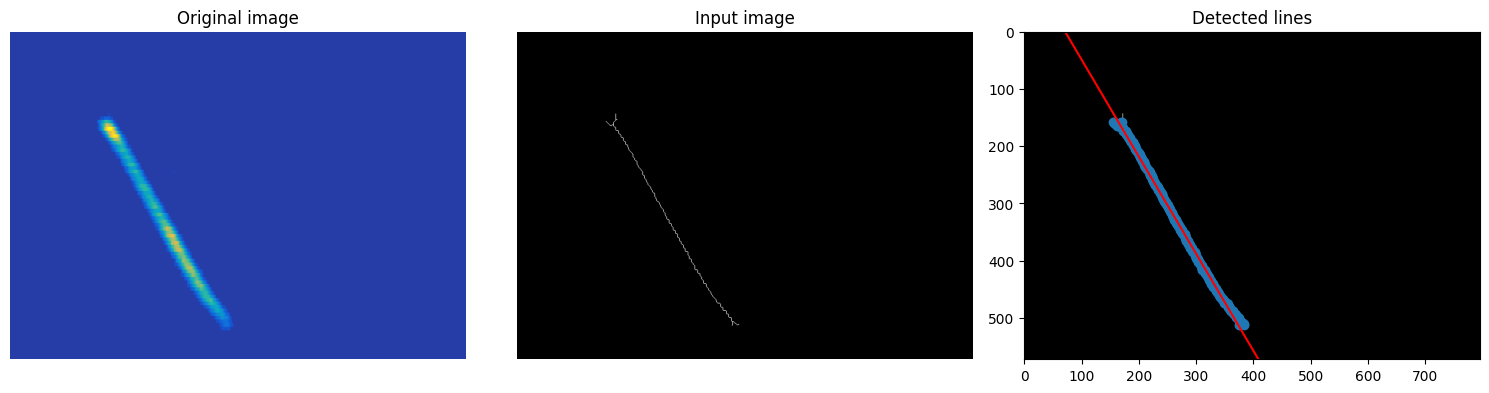

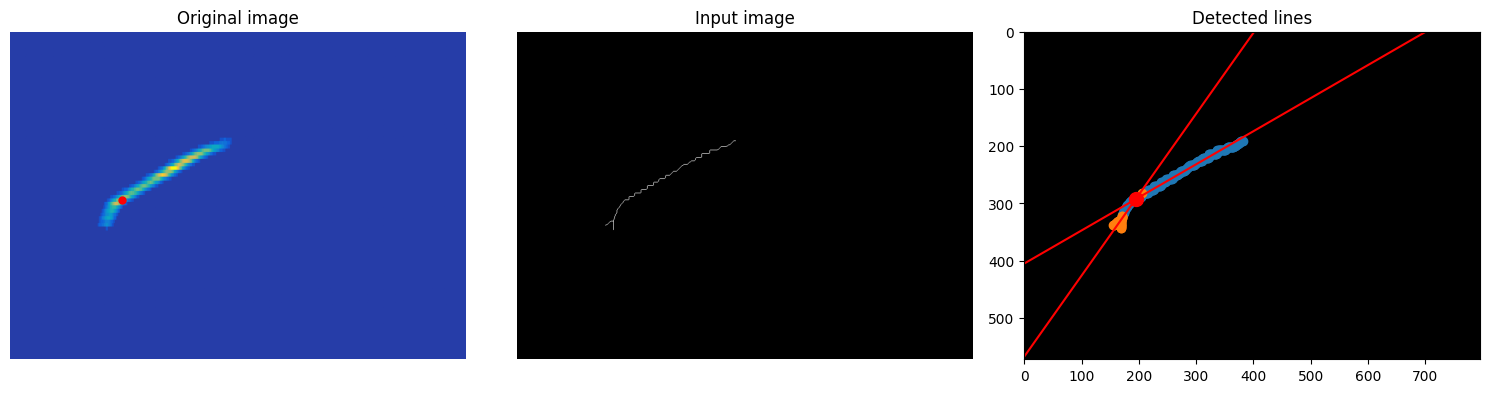

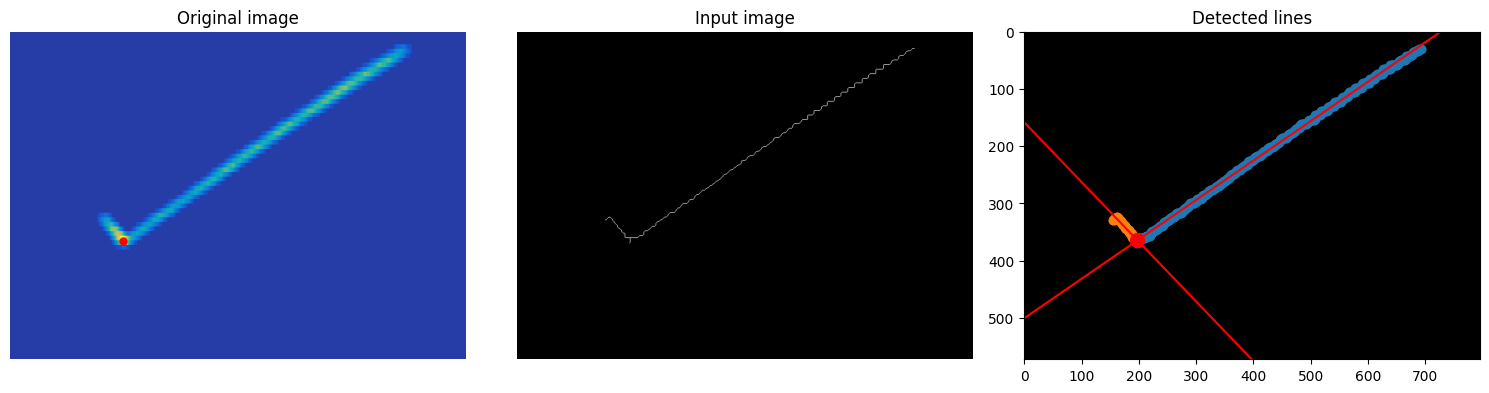

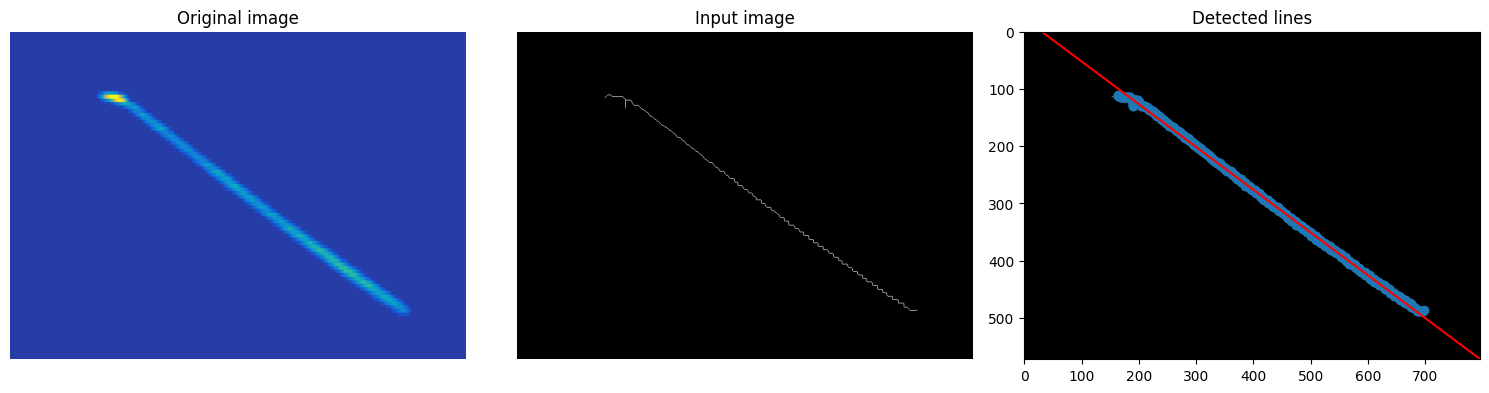

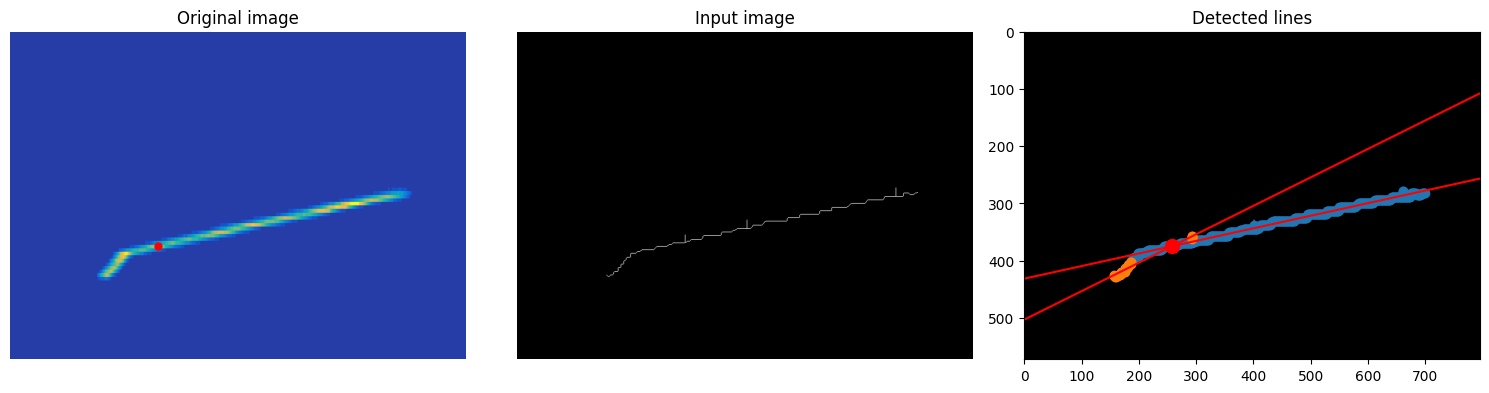

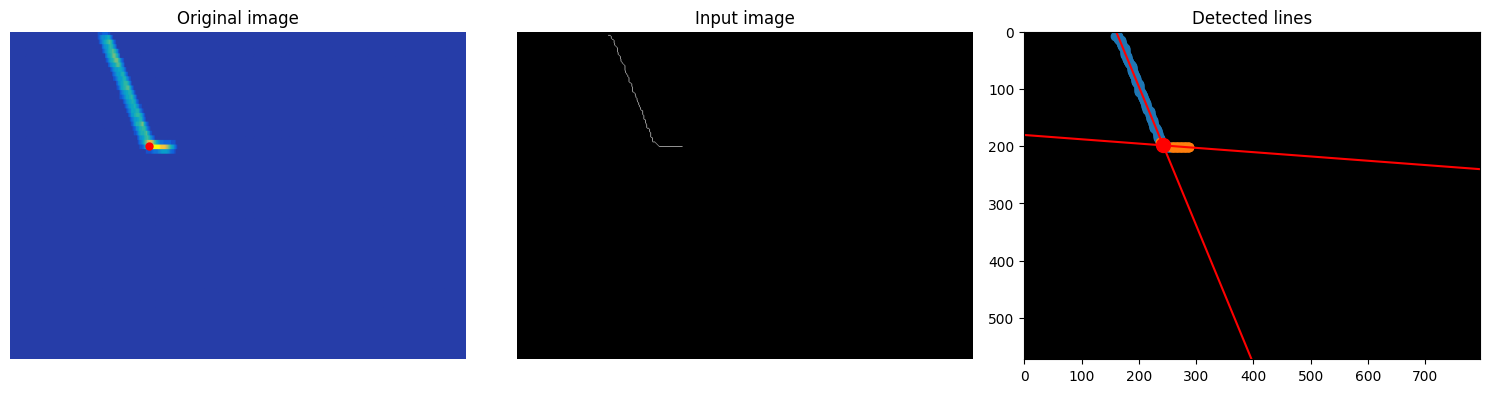

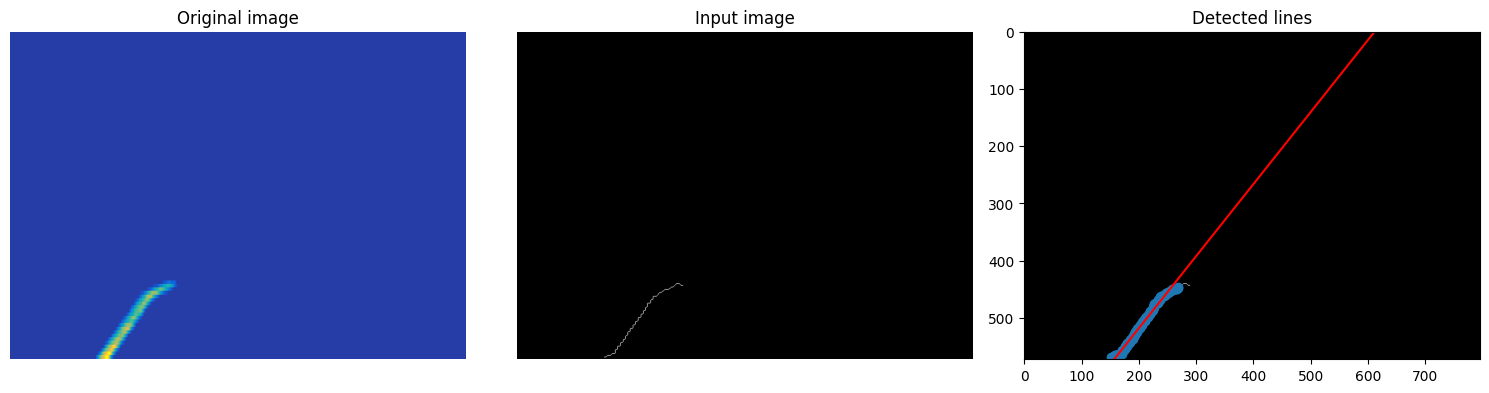

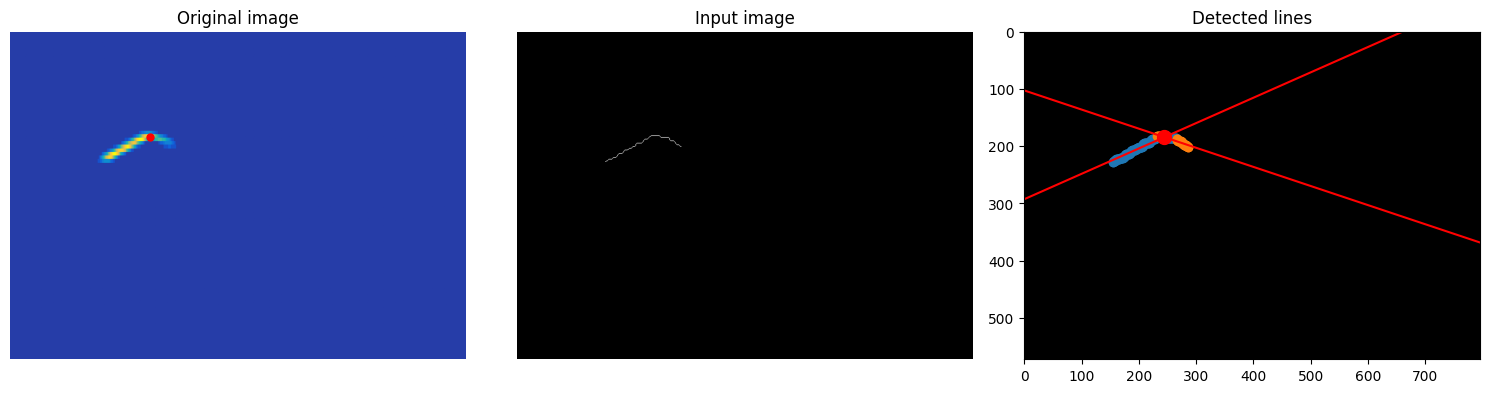

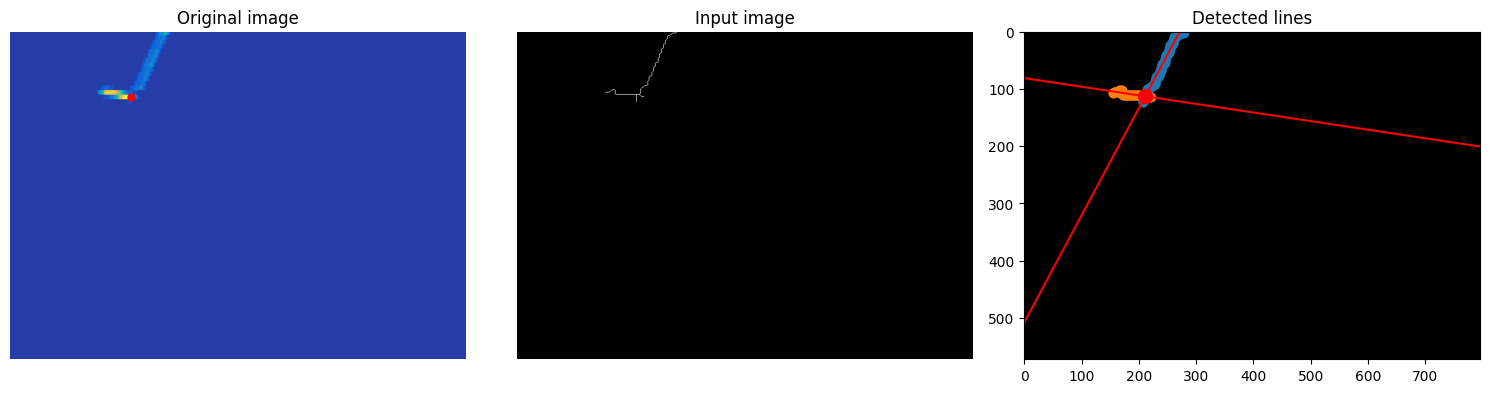

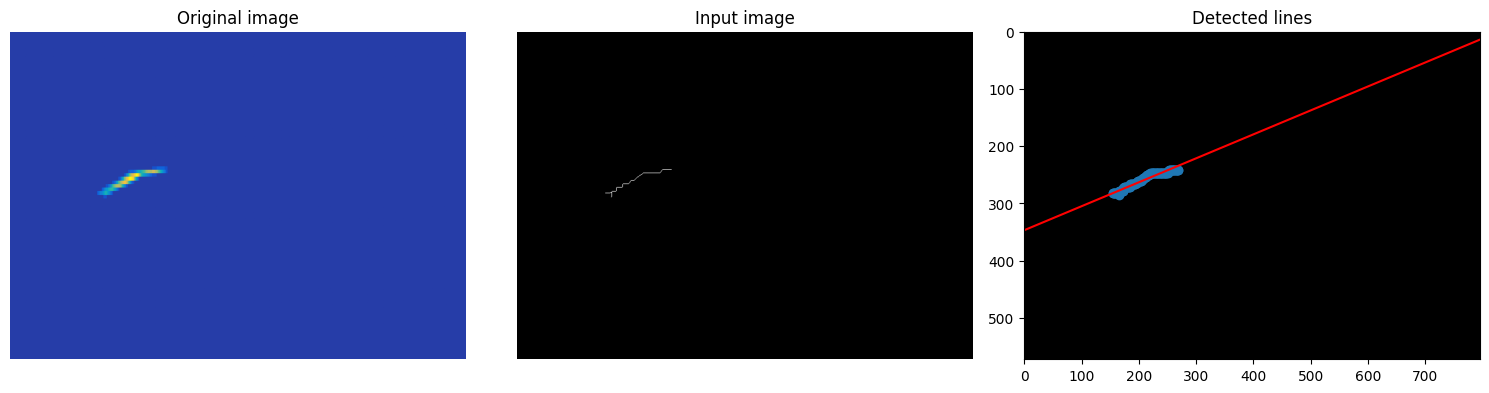

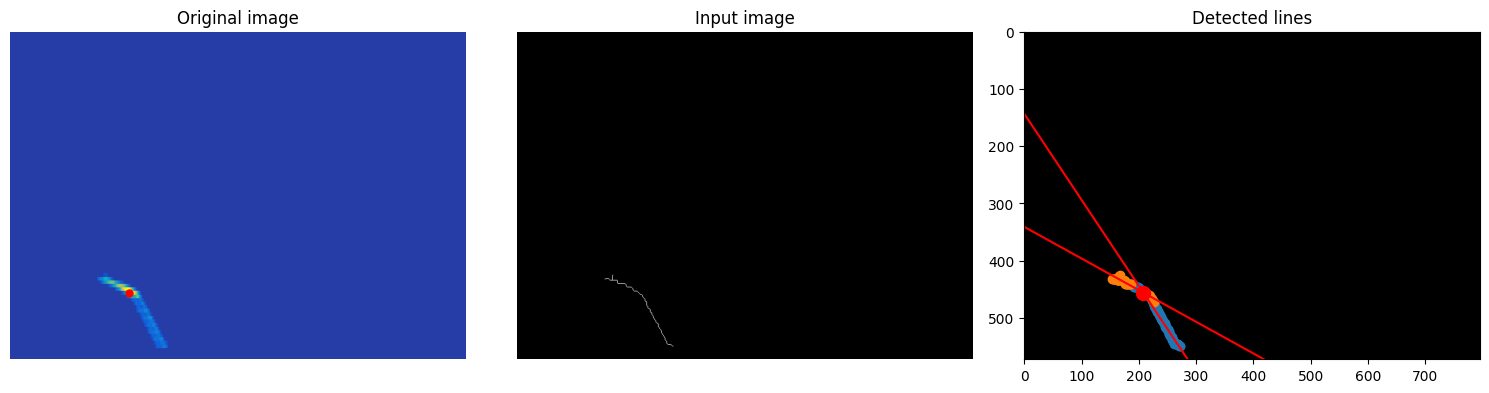

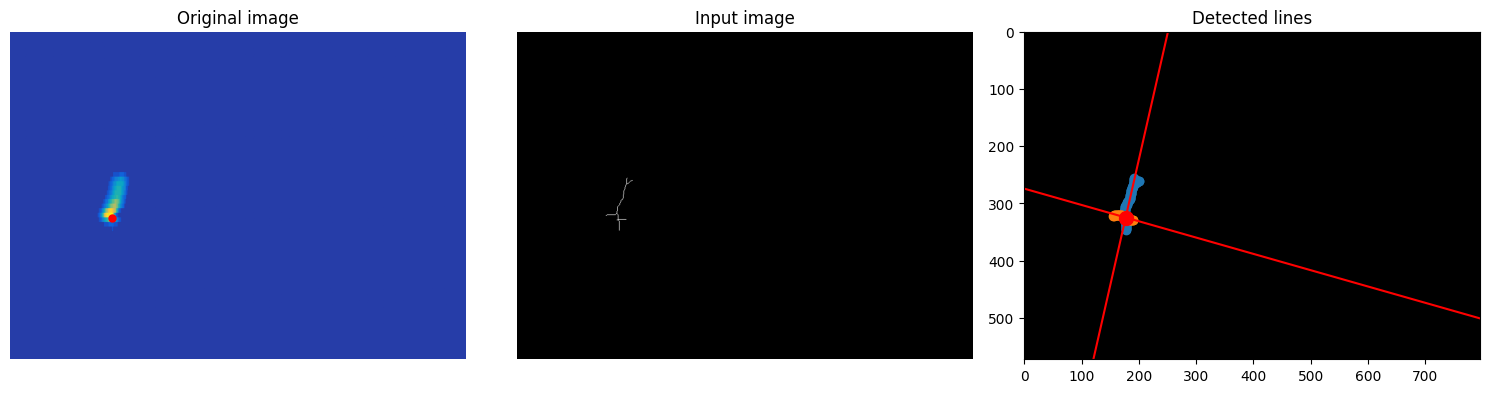

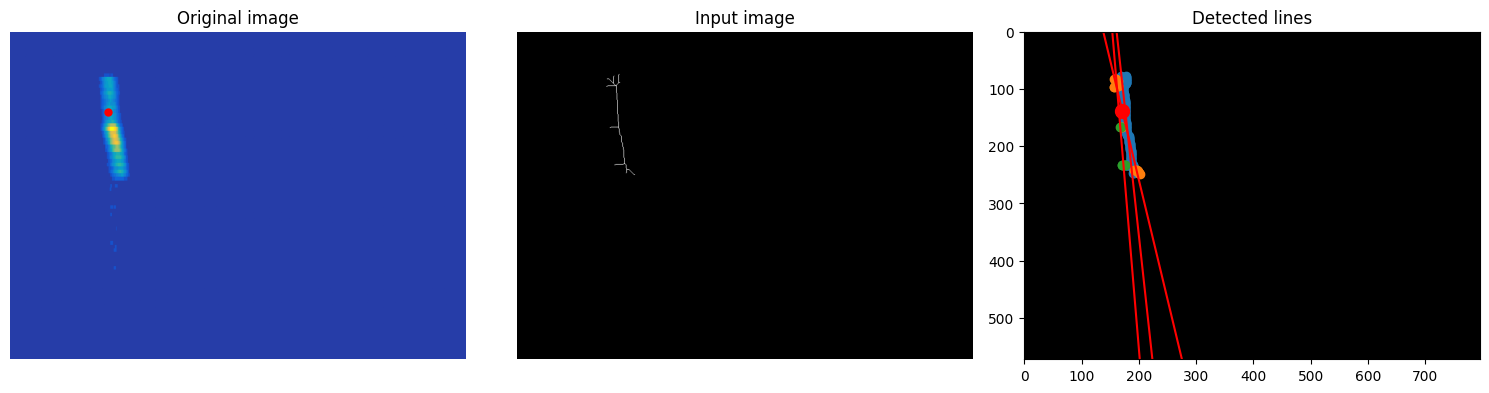

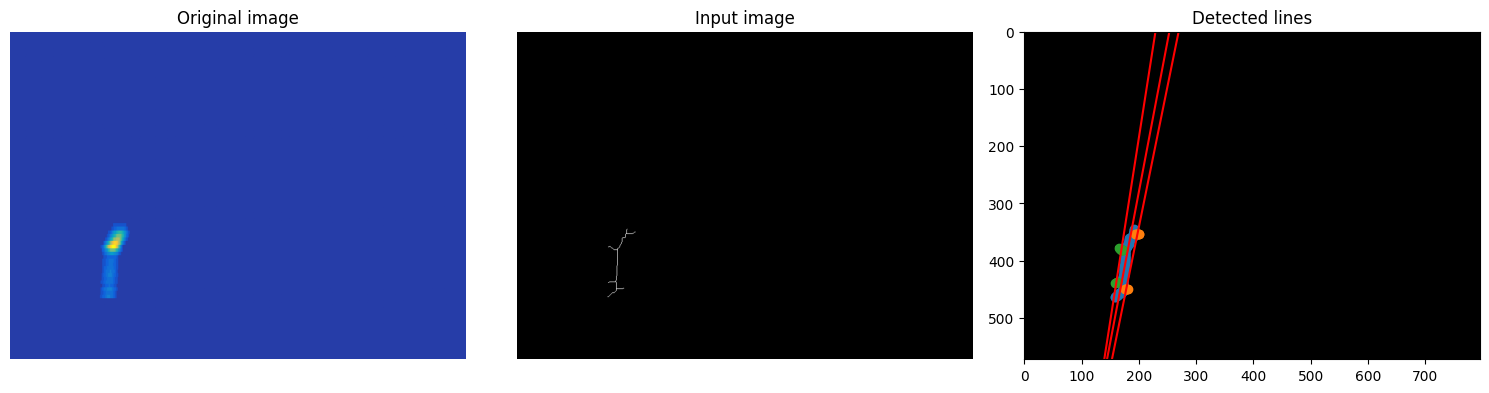

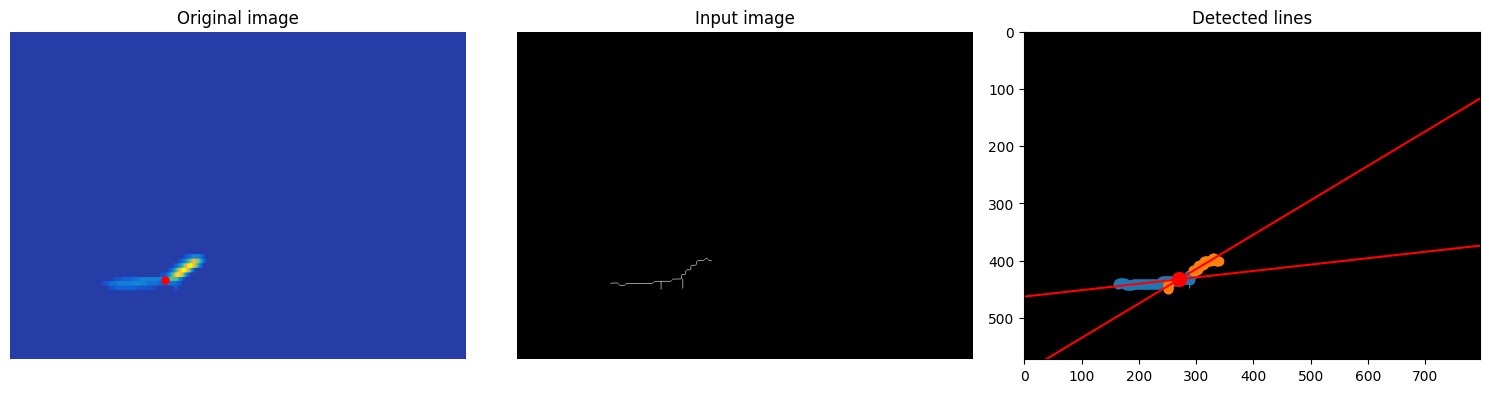

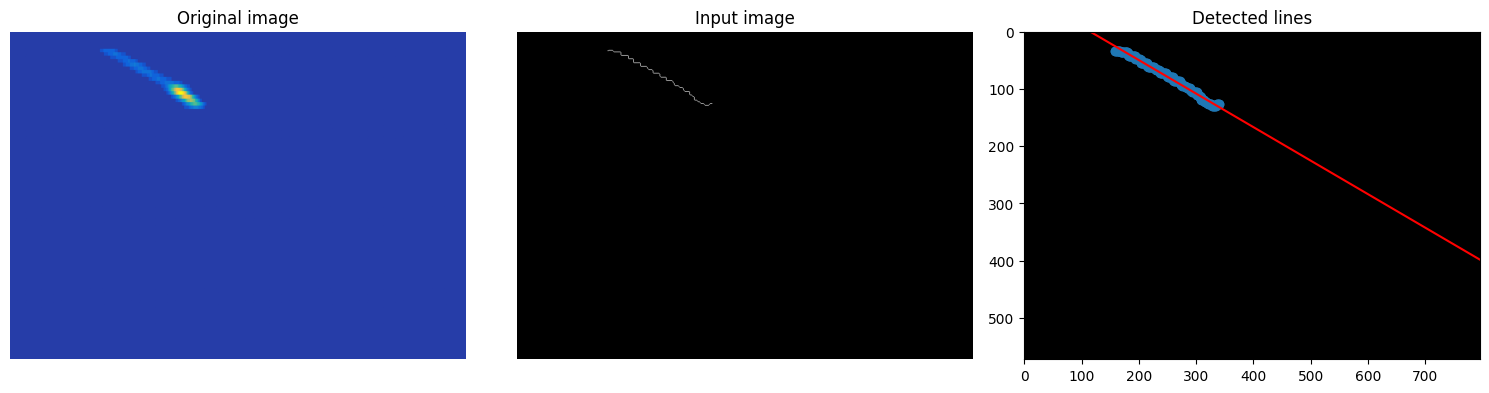

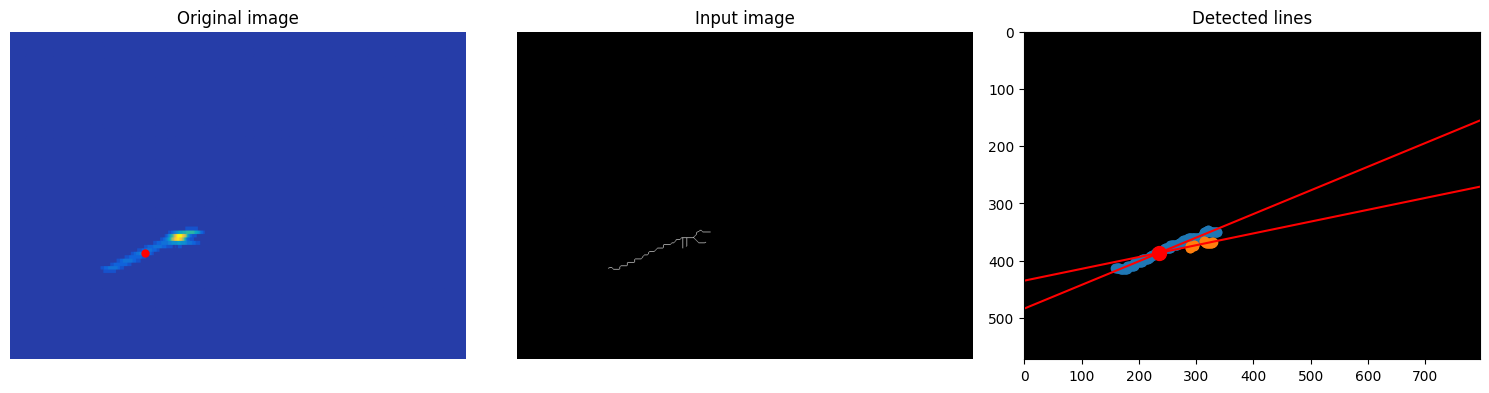

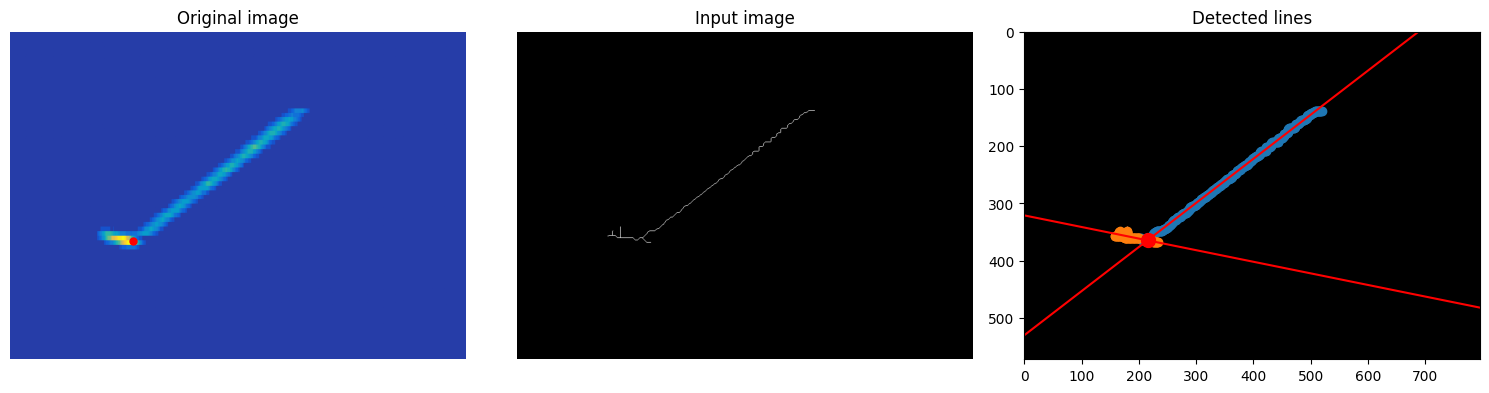

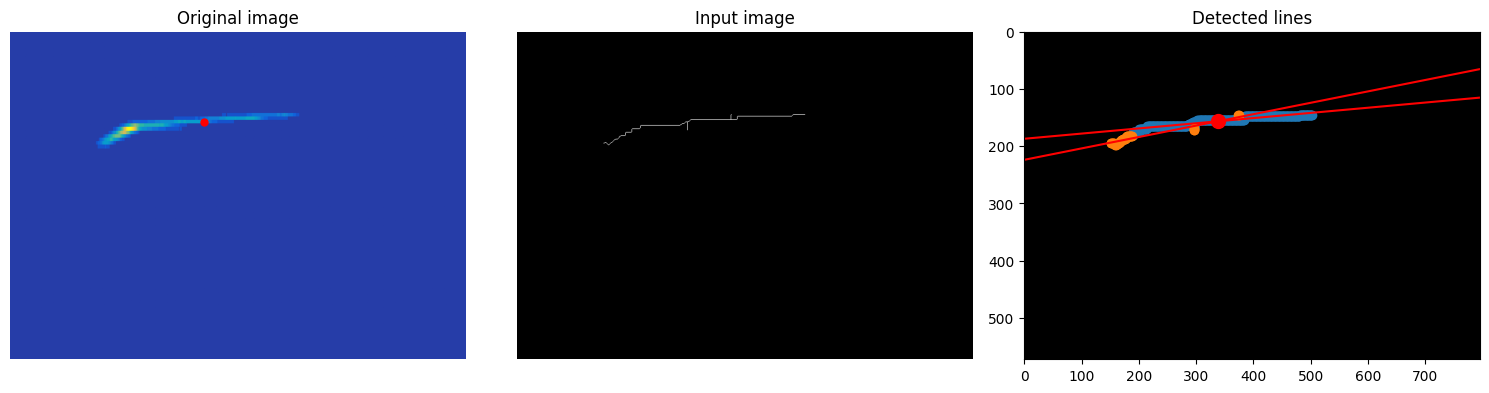

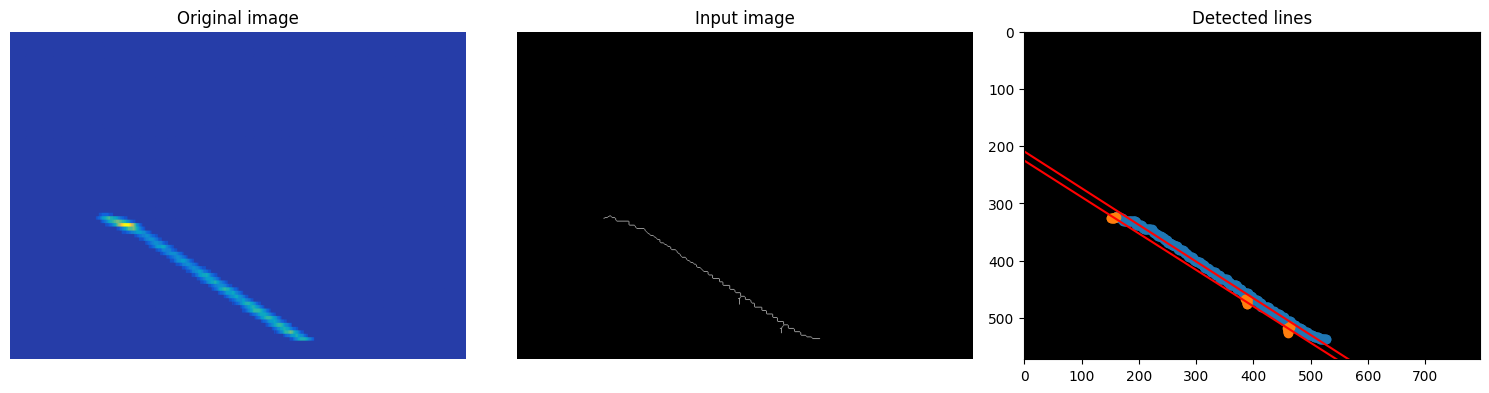

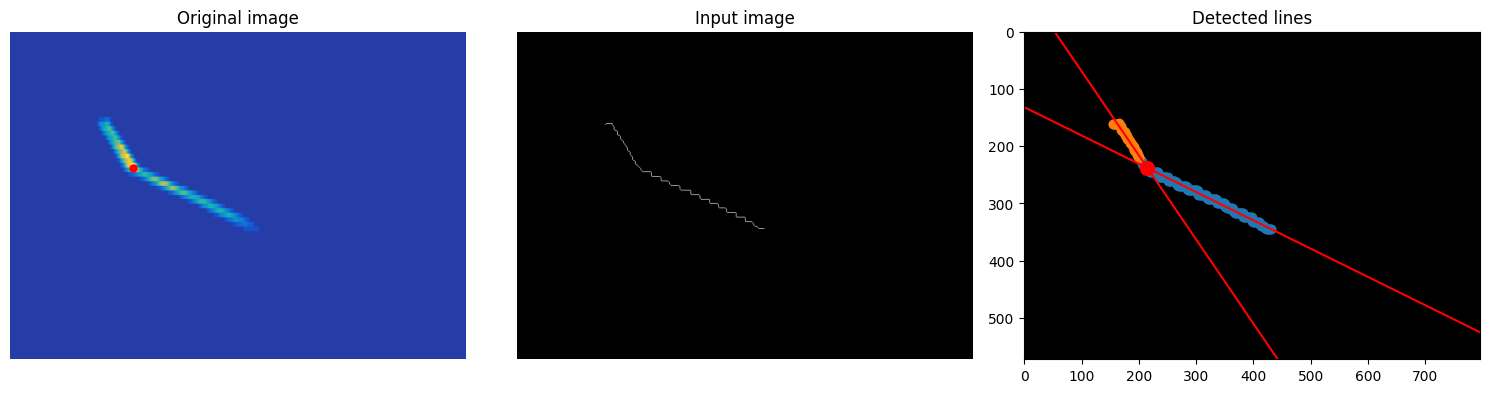

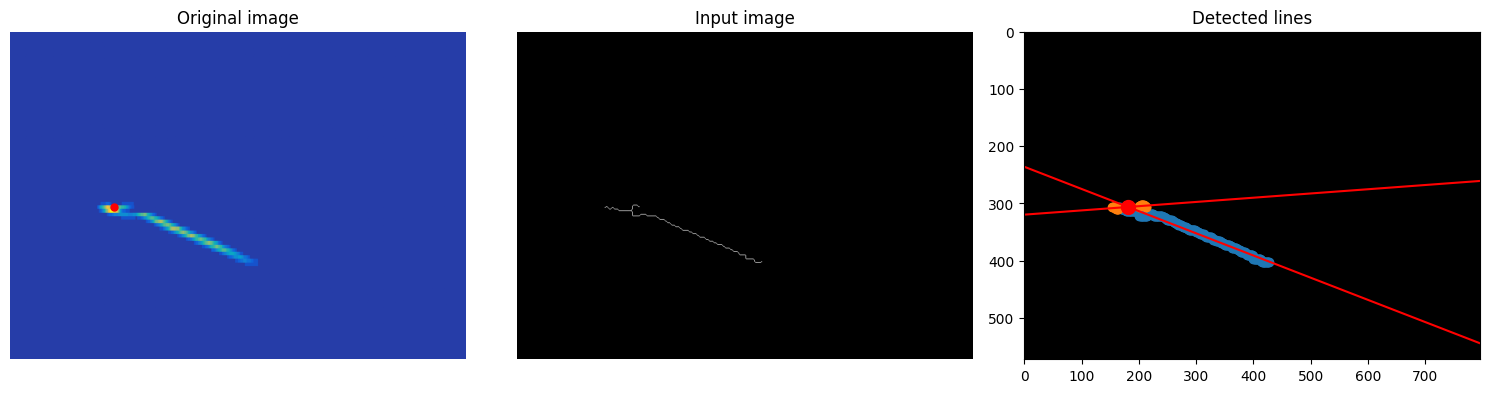

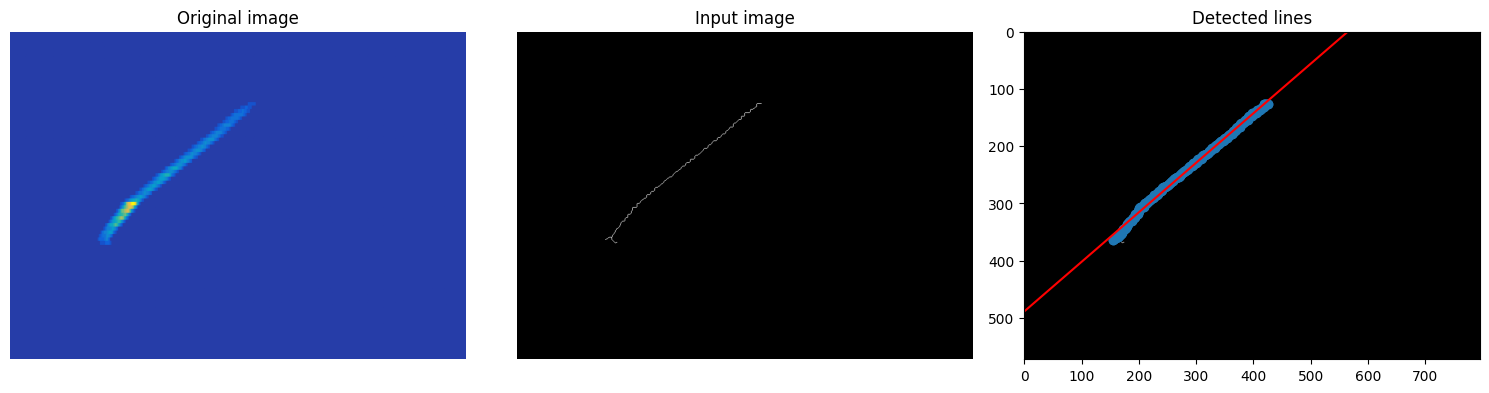

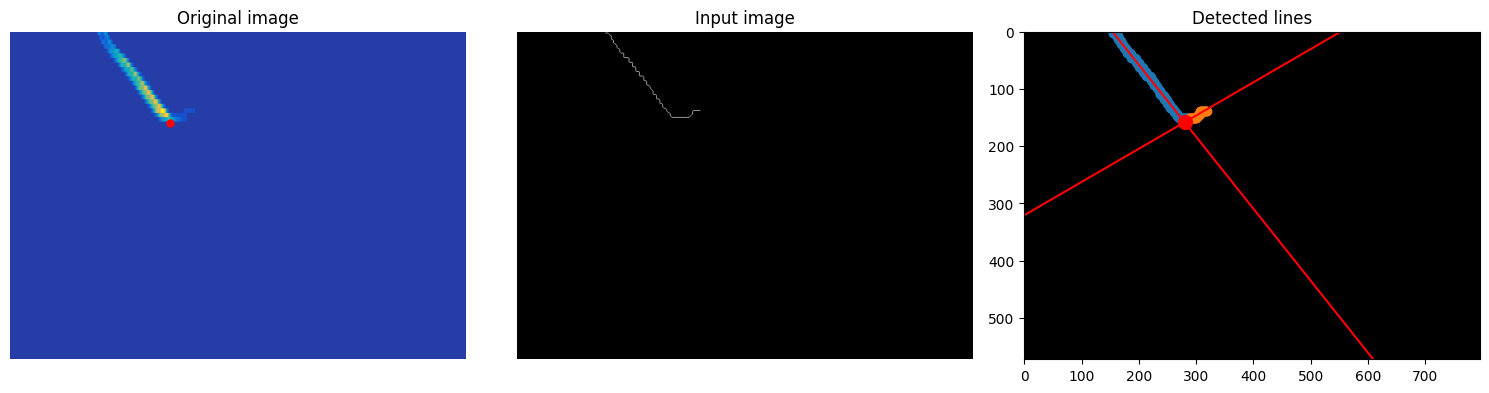

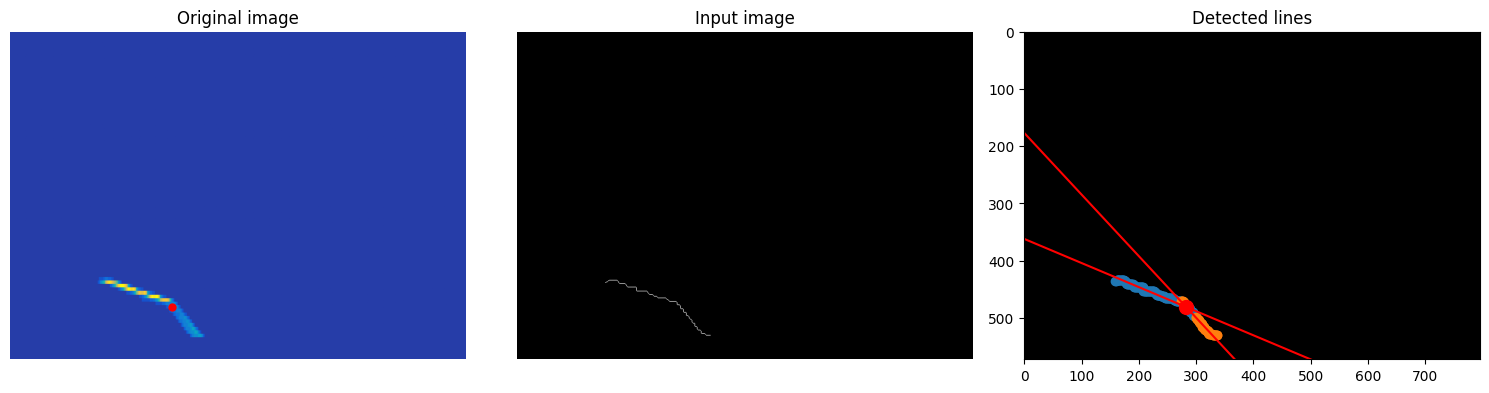

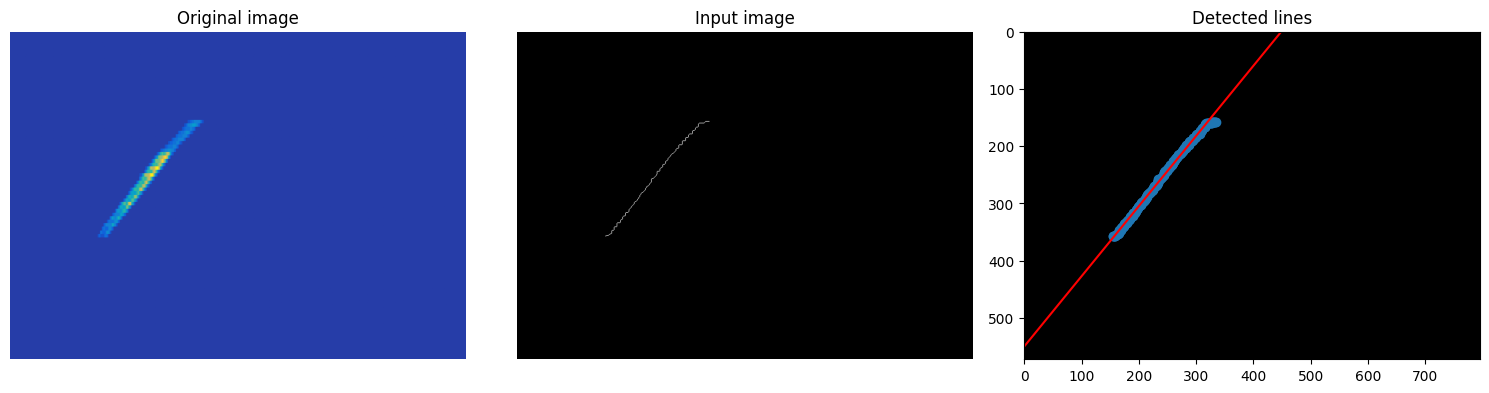

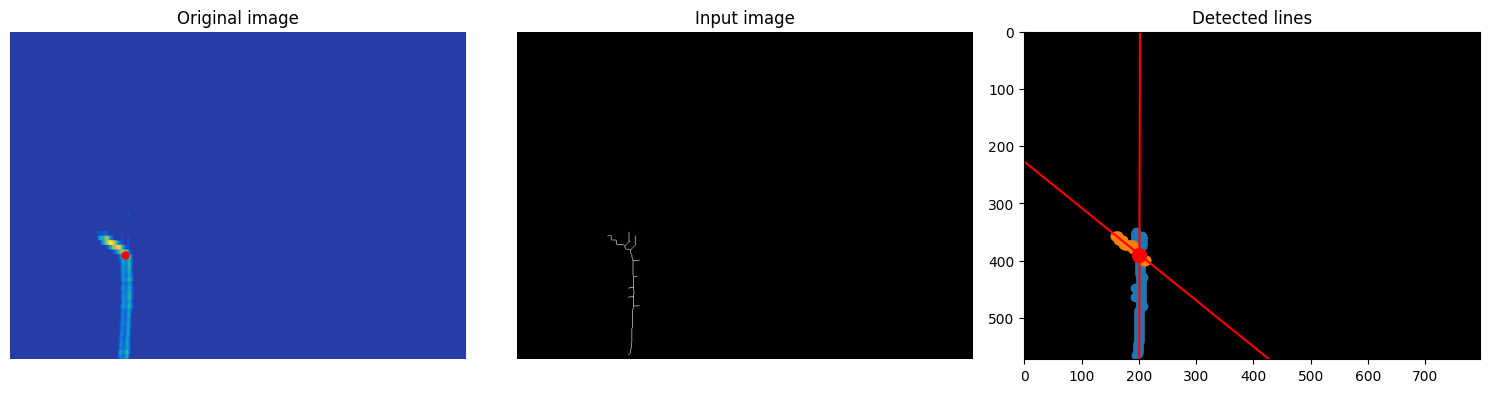

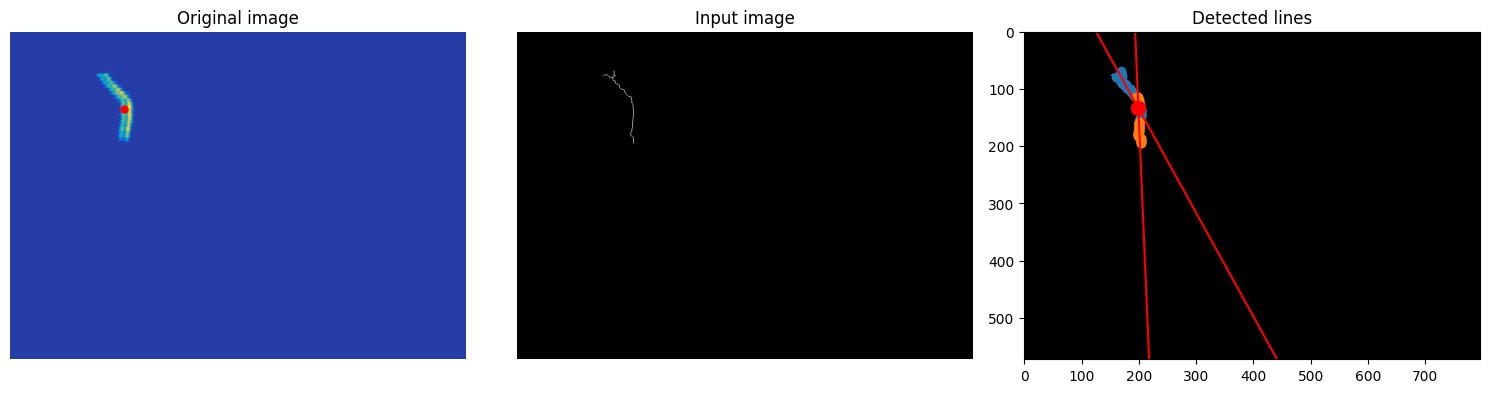

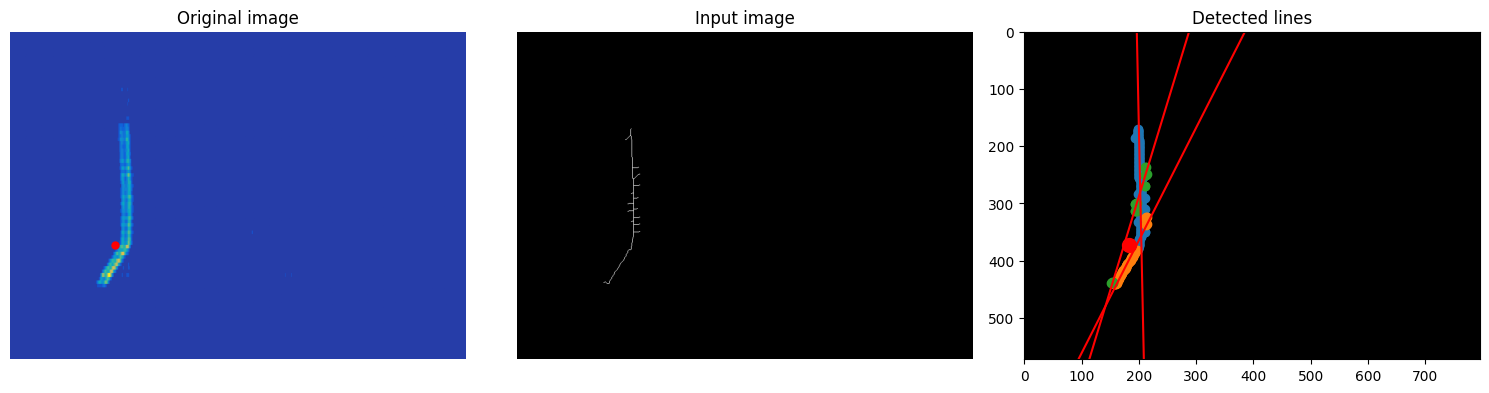

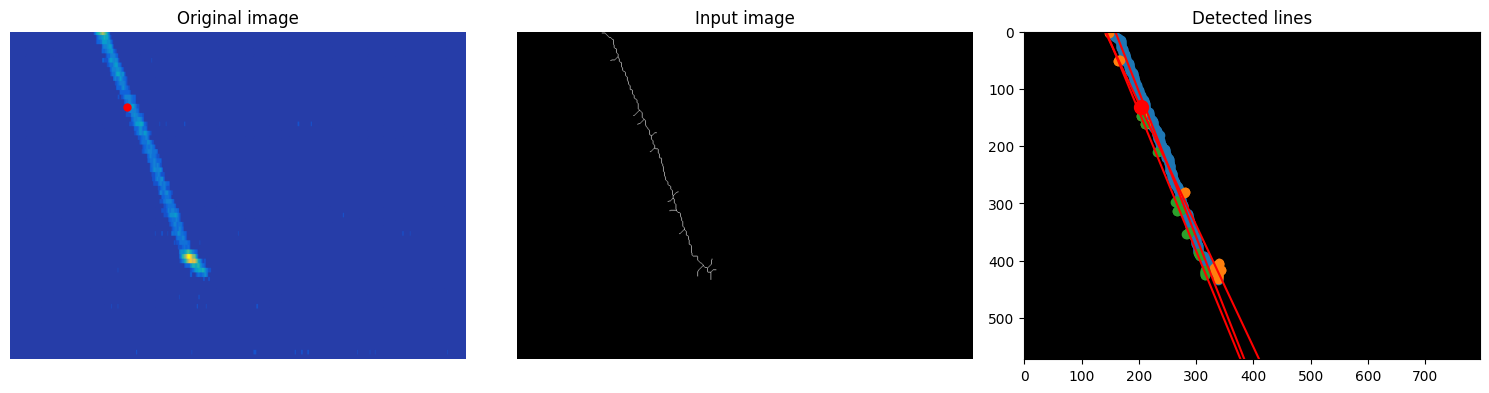

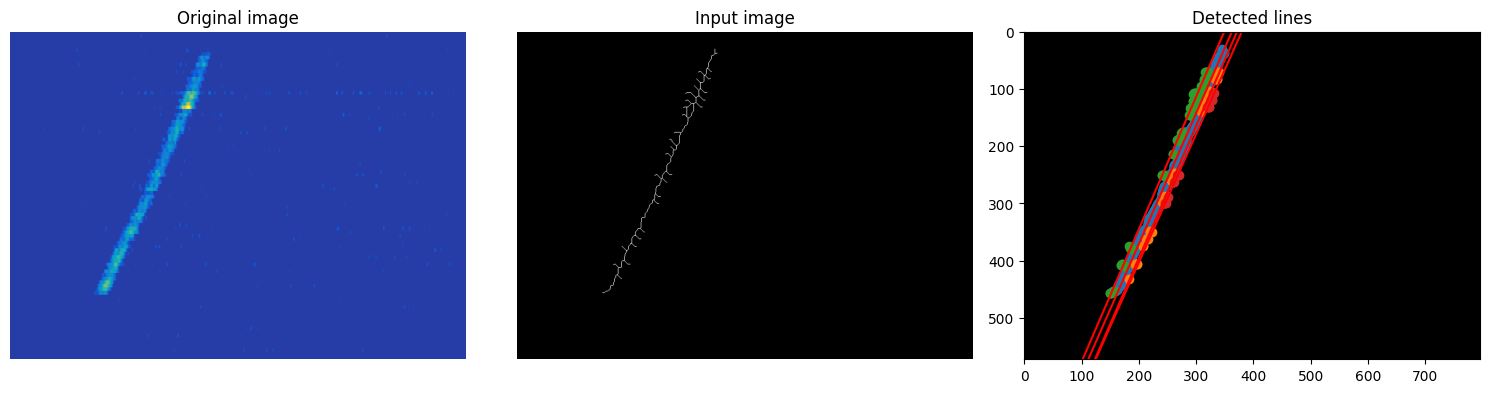

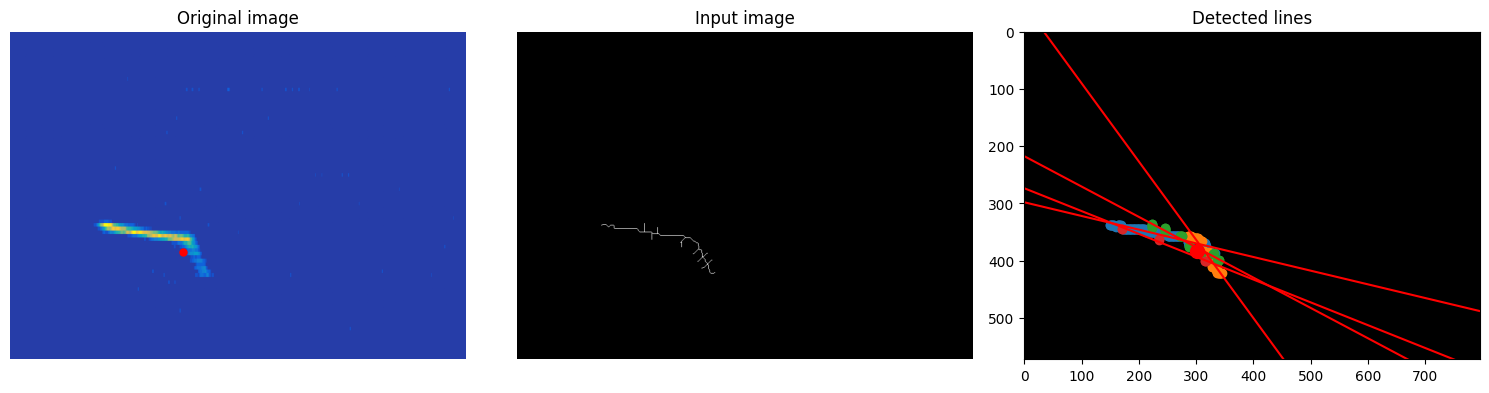

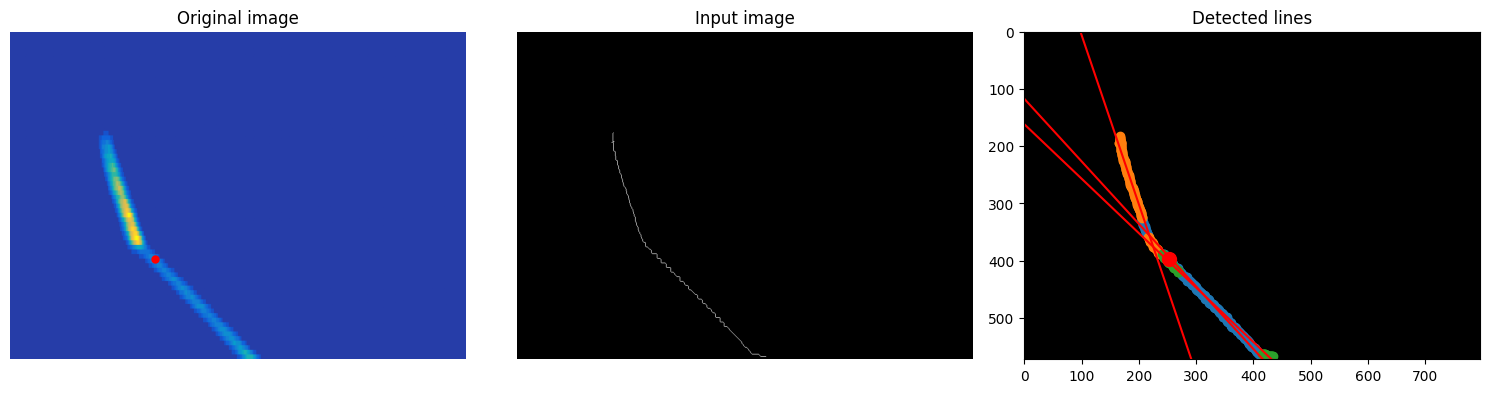

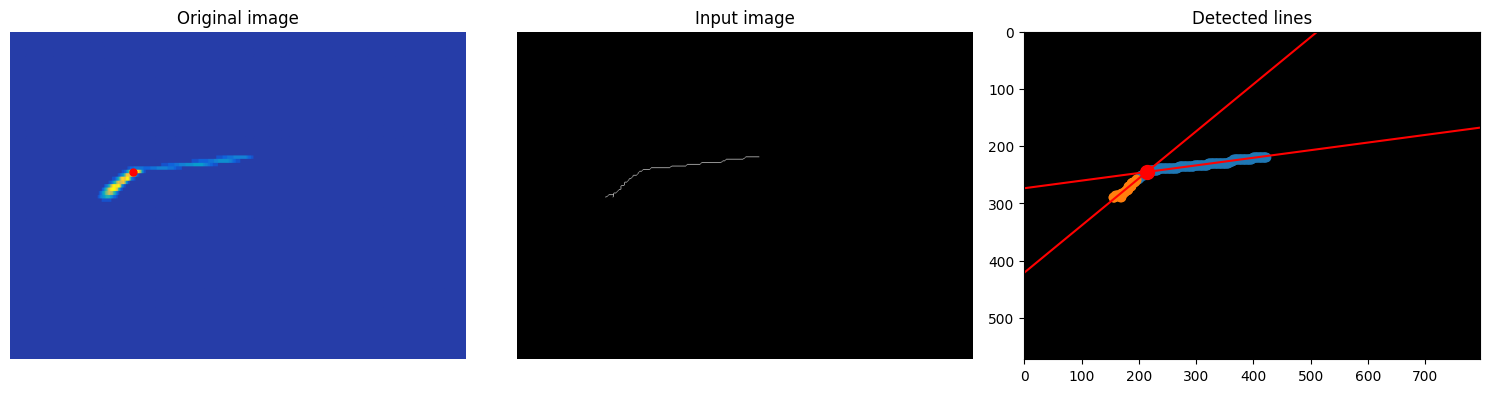

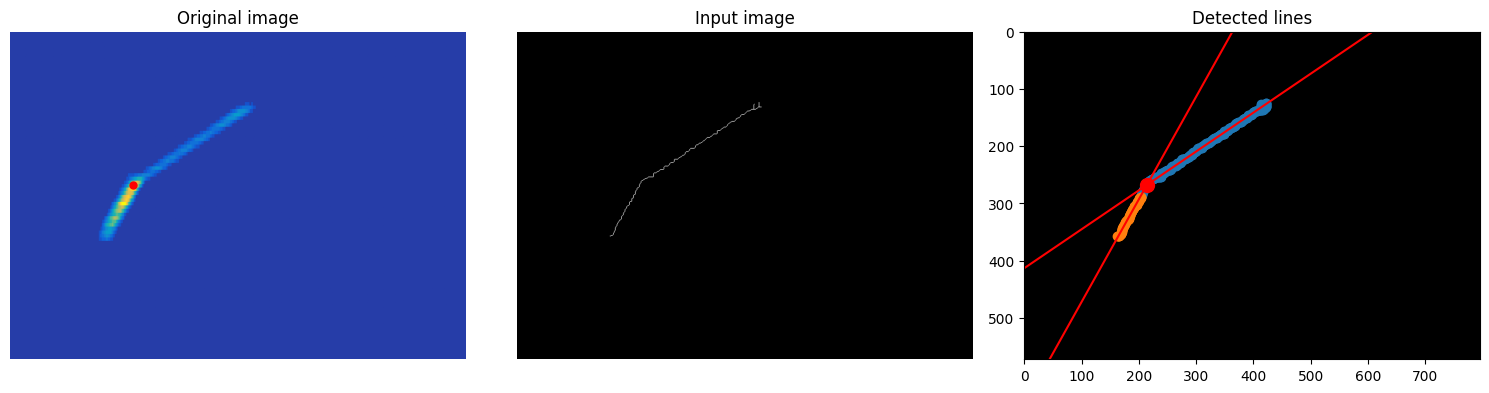

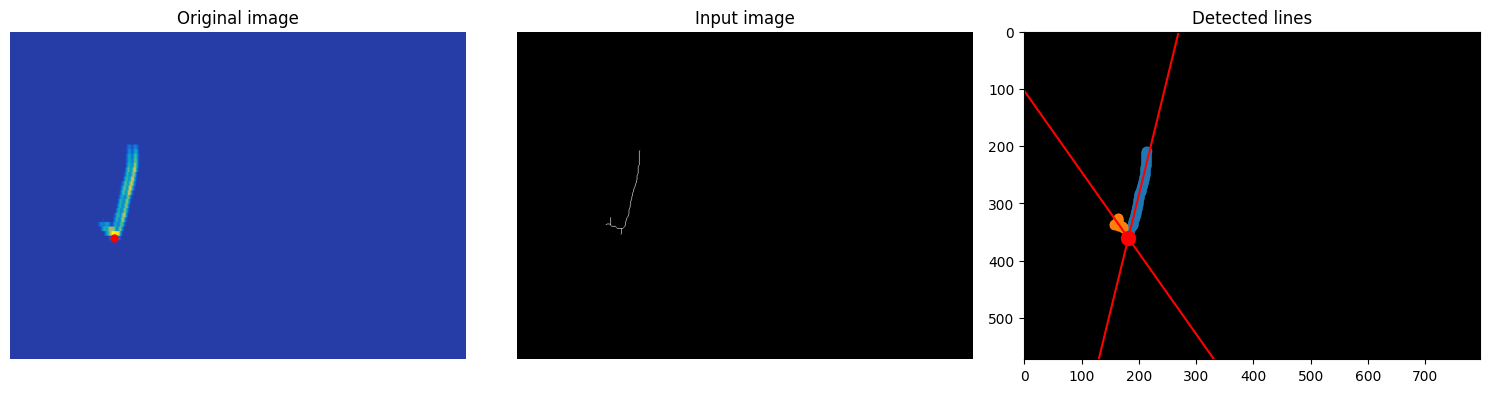

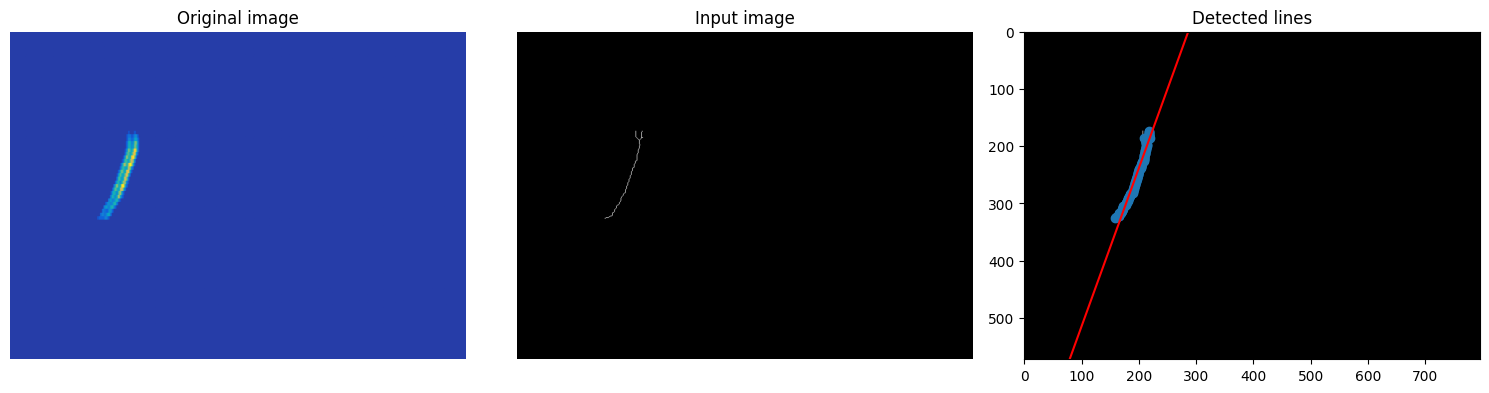

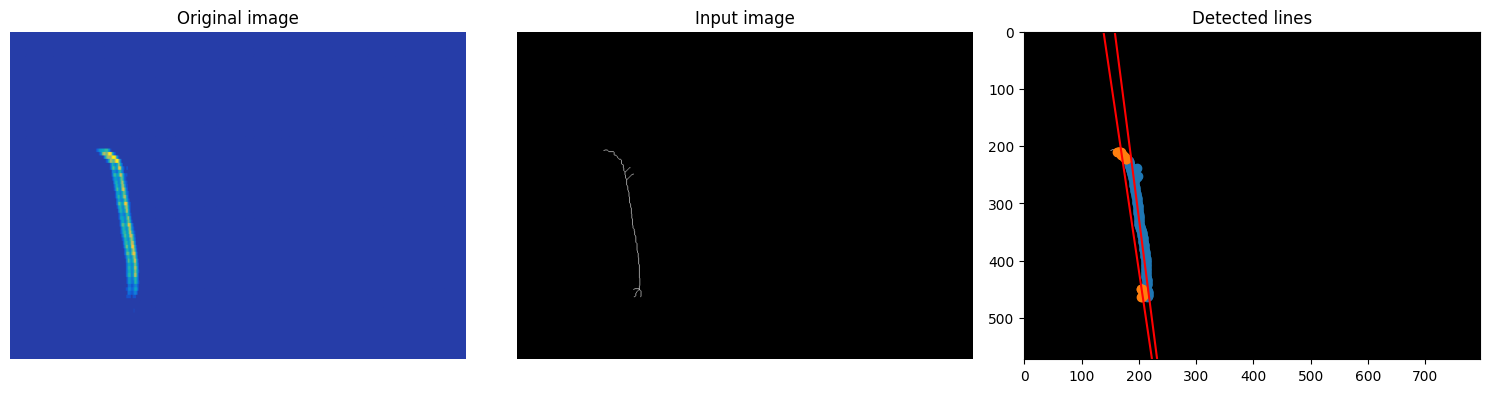

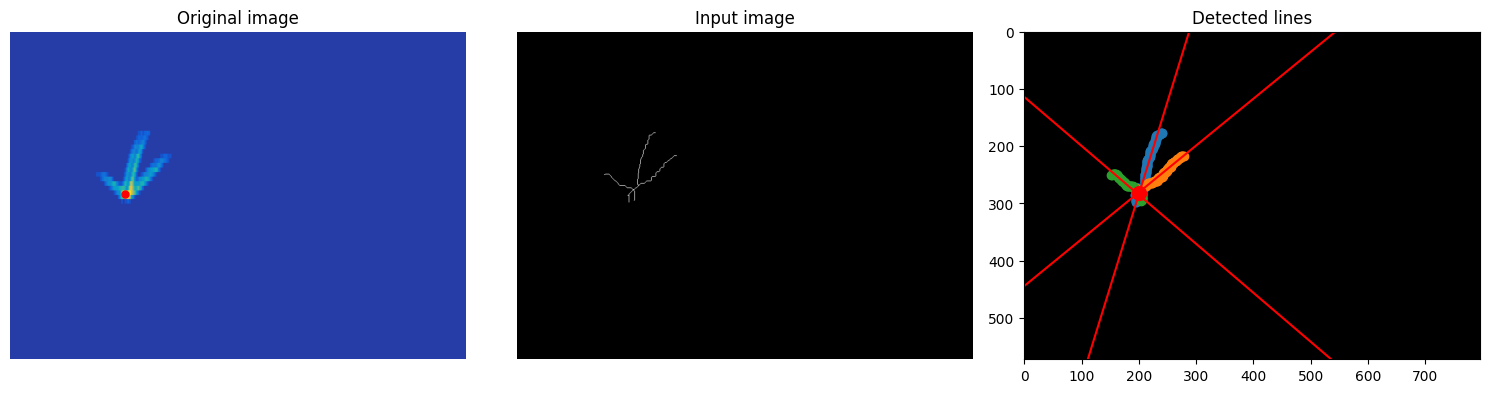

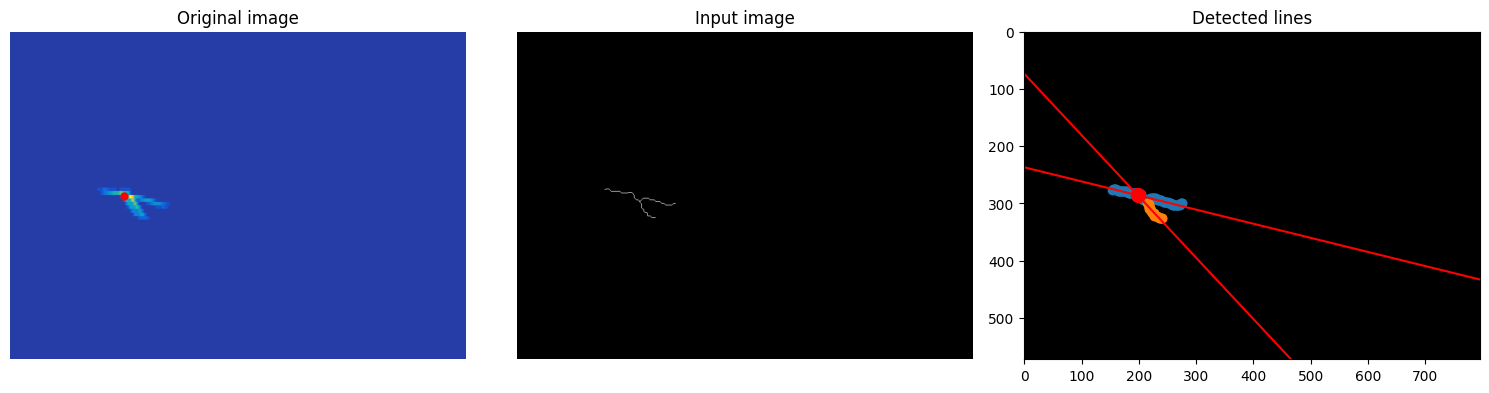

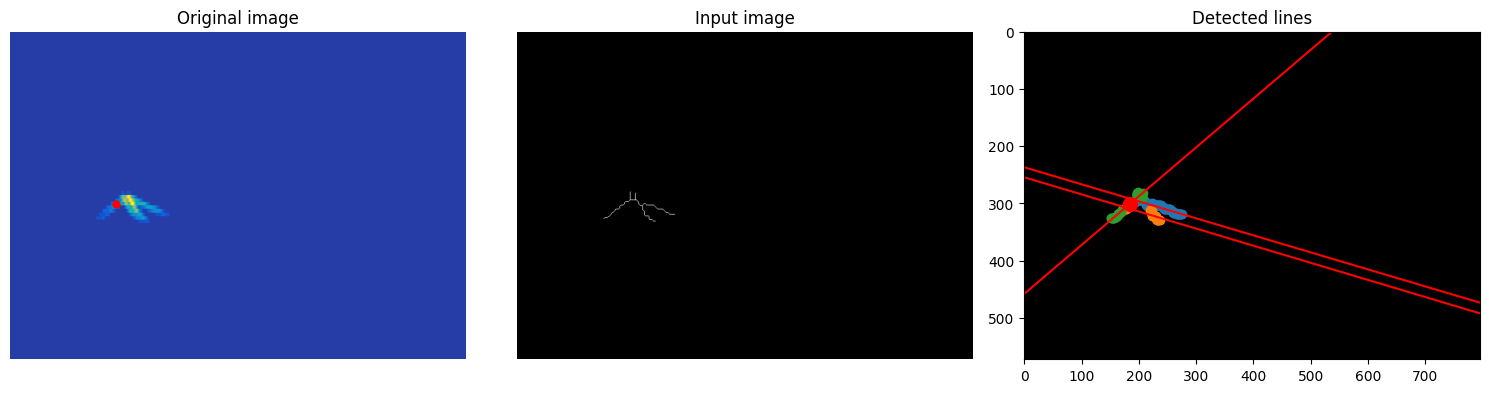

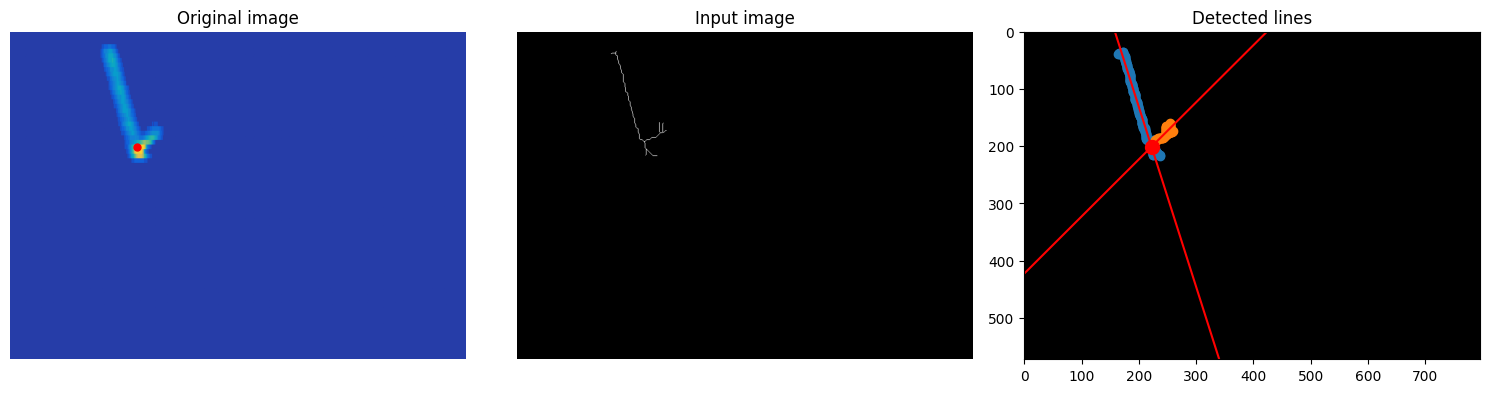

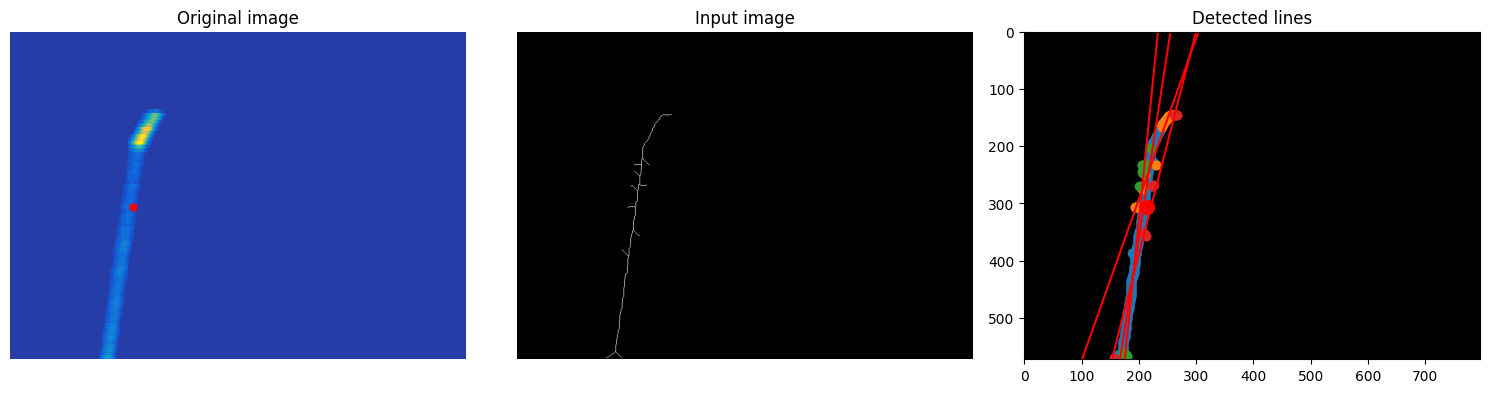

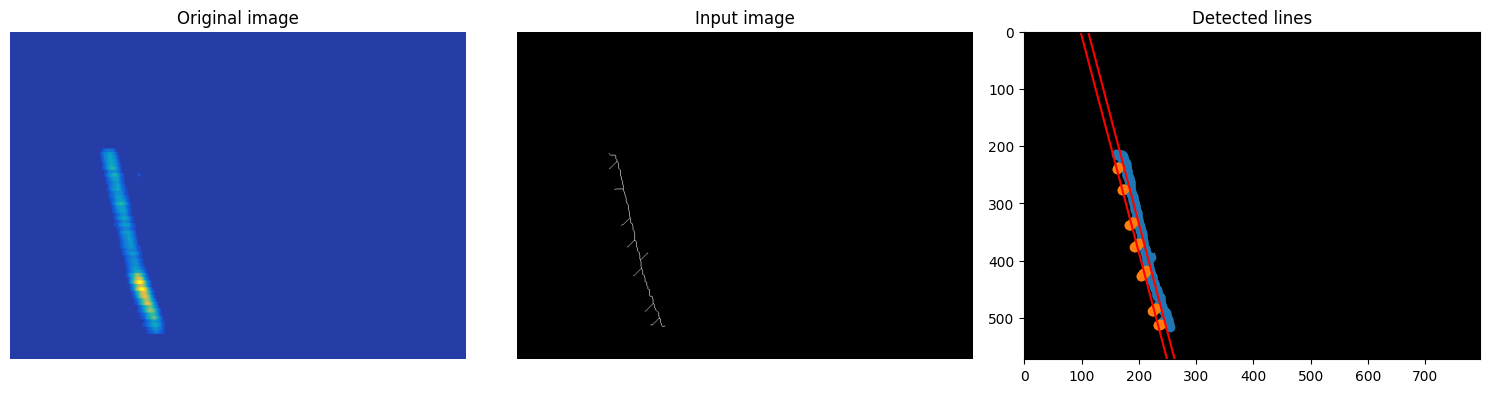

In [2]:
from skimage.morphology import skeletonize
from skimage.measure import LineModelND, ransac
from skimage.color import rgb2gray
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import sys
import os
sys.path.append("/home/gant/Documents/tpcanalysis/python_comp/src")
from openImage import openImage


# Remove small shapes. 
def cleanNoise(image, min_size_threshold = 100):

    # Apply a different label for each shape.
    labeled_image, num_labels = ndimage.label(image)

    # Count the size of each labes which is the size of each shape. Remember to address the fact that 0 is not a real label and is background.
    sizes = np.bincount(labeled_image.ravel())

    # Exclude the background label (0) from the sizes array. 
    sizes[0] = 0

    # Remove small connected components
    filtered_image = np.where(sizes[labeled_image] < min_size_threshold, 0, 1)

    return filtered_image


def fitImage(path_and_name_input, path_and_name_output=None):

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    original_image = test_image.m_data

    # Black and white
    test_image.m_data = rgb2gray(test_image.m_data)
    test_image.m_data = np.where(test_image.m_data < 0.3, 0, 1)

    test_image.m_data = cleanNoise(test_image.m_data, 100)
    test_image.m_data = skeletonize(test_image.m_data)

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title('Original image')
    ax[0].set_axis_off()

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title('Input image')
    ax[1].set_axis_off()

    ax[2].imshow(test_image.m_data, cmap=cm.gray)
    ax[2].set_ylim((test_image.m_data.shape[0], 0))
    # ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    lines_eq = []

    ransac_data = test_image.m_data

    points = np.argwhere(ransac_data == 1)[:, ::-1]

    min_samples = 20

    for i in range(10):

        if (len(points) < min_samples + 1):
            # print(f"\nStopped at iteration number {i}\n\n")
            break

        model, inliers = ransac(
            points, LineModelND, min_samples=min_samples, residual_threshold=7, random_state=0)

        outliers = inliers == False

        if (type(model) is type(None)):
            break

        ax[2].scatter(points[inliers][:, 0], points[inliers][:, 1])

        if (model.params[1][0] == 0):
            slope = 999  # temporary fix
        else:
            slope = model.params[1][1] / \
                model.params[1][0]
        intercept = model.params[0][1] - \
            slope * model.params[0][0]

        # print(f"Equation: y = {slope}*x+{intercept}")
        # print(f"Line from {model.params[0][0]}, {model.params[0][1]} to {model.params[1][0]}, {model.params[1][1]}")

        x = np.arange(0, test_image.m_data.shape[1])
        # x = np.arange(points[inliers][:, 0].min(), points[inliers][:, 0].max())
        y = slope * x + intercept

        ax[2].plot(x, y, label="fitted line", color='red')

        points = points[outliers]

        lines_eq.append([slope, intercept])

    intersections = []

    for i, (slope1, intercept1) in enumerate(lines_eq):
        for slope2, intercept2 in lines_eq[i + 1:]:
            if slope1 != slope2:  # Lines are not parallel
                x = (intercept2 - intercept1) / (slope1 - slope2)
                y = slope1 * x + intercept1
                if (x > 0 and x < 800 and y > 0 and y < 600):
                    intersections.append((x, y))

    if (len(intersections) != 0):
        average_x = sum(
            map(lambda point: point[0], intersections)) / len(intersections)
        average_y = sum(
            map(lambda point: point[1], intersections)) / len(intersections)
        ax[2].plot(average_x, average_y, marker='o',
                   markersize=10, color='red')
        ax[0].plot(average_x, average_y, marker='o', markersize=5, color='red')

    plt.tight_layout()
    # plt.show()
    plt.savefig(path_and_name_output)


# Make sure the dirs exist befoe calling the function. Don't have time to make sure in code.
image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages2/"

image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))